# Prerequsites

In [1]:
# log the time of the experiment
from datetime import datetime
import time

exp_time = datetime.now()
exp_time_str = exp_time.strftime("_%H_%M_%S")
date_str = exp_time.strftime("%m_%d_%y")

In [2]:
# Path management for MacOS and Windows
from pathlib import Path
import os, sys

scriptPath = Path(sys.path[0])
parentPath = Path(sys.path[0]).parent
#libPath = Path("/home/tw329/GitHub/ONN_MNIST/")
libPath = Path("C:\\Users\\Logan\\Documents\\GitHub\\ONN_MNIST")
sys.path.append(libPath.as_posix())
sys.path.append("C:\\Users\\Logan\\Documents\\GitHub\\mcmahon_lab_devices") 

# Set the working directory (to save the files)
resultPath = scriptPath

slmWeightPath = resultPath / "slm_weights"
if not os.path.exists(slmWeightPath.as_posix()):
    os.makedirs(slmWeightPath.as_posix())
    
phoneImagePath = resultPath / "phone_images"
if not os.path.exists(phoneImagePath.as_posix()):
    os.makedirs(phoneImagePath.as_posix())
    
saveDataPath = resultPath / "saved_data"
if not os.path.exists(saveDataPath.as_posix()):
    os.makedirs(saveDataPath.as_posix())
    
print(resultPath)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC


In [3]:
from __future__ import print_function
import os, sys
import argparse
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
%matplotlib notebook

# Instrument Controls

In [5]:
# Configure the SLM
from src.slmpy import SLMdisplay   # Popoff's simple package for controlling SLM

slm = SLMdisplay(isImageLock = True)

LUT_used="AmpLUT_basedon_100120slmbackcali_140509_start5.lut"

slmParamFile = resultPath / ''.join(["slm_info", exp_time_str, ".txt"])
with open(slmParamFile,'w') as slmparams:
    slmparams.write('LUT\t\t\t{}\n'.format(LUT_used))
slmparams.close()


C:/Users/Logan/Documents/GitHub/ONN_MNIST\src\slmpy.py:39: wxPyDeprecationWarning: Call to deprecated item EmptyImage. Use :class:`Image` instead.
  self.img = wx.EmptyImage(2,2)


In [6]:
import pyvisa
from devices import Agilent54845A as AgilentOscope

rm = pyvisa.ResourceManager("C:\\WINDOWS\\System32\\visa64.dll")
gpib_id = rm.list_resources()[-1]
oscope = AgilentOscope(rm.open_resource(gpib_id))
oscope.set_waveform_source(1)

def oscope_info(oscope):
    measure_state = {}
    measure_state["ID"] = oscope.id()
    measure_state["x_range"] = oscope.get_xrange()
    measure_state["x_unit"] = oscope.get_xunits()
    measure_state["y_range"] = oscope.get_yrange()
    measure_state["y_unit"] = oscope.get_yunits()
    measure_state["y_offset"] = oscope.get_offset()
    measure_state["y_bounds"] = [oscope.get_bottom_bound(), oscope.get_top_bound()]
    return measure_state

In [7]:
# Configure the phone

from Android_Display_Control.Remote_Display.image_stream import AndroidOpenAccessoryBridge as AOAB

PIXEL_VENDOR_ID = 0x18d1
PIXEL_UNCONFIG_ID =  0x4ee7
PIXEL_CONFIG_ID = 0x2d01

# Create an AOAB object for managing data send/receive via USB
aoab = AOAB(PIXEL_VENDOR_ID, PIXEL_UNCONFIG_ID, 
  PIXEL_CONFIG_ID,
  manufacturer='ImageStreamManufacturer',
  model='ImageStream1',
  description='Stream Images to Android',
  version=1,
  uri=('https://github.com/chris-blay/android-open-accessory-bridge'),
  serial='AoabSerial')

Exception ignored in: <function _AutoFinalizedObjectBase.__del__ at 0x000002C0617F6D90>
Traceback (most recent call last):
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 84, in __del__
    self.finalize()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 144, in finalize
    self._finalizer()
  File "C:\Users\Logan\Anaconda3\lib\weakref.py", line 552, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 104, in _do_finalize_object_ref
    obj._do_finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 71, in _do_finalize_object
    self._finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _finalize_object
    _lib.libusb_unref_device(self.devid)
OSError: exception: access violation writing 0x0000000000000024


In [8]:
def PIL_to_bytestream(img_px):
    array_px = np.array(img_px)
    byte_array_px = bytearray()

    for i in range(array_px.shape[0]):
        for j in range(array_px.shape[1]):
            byte_array_px.append(array_px[i, j, 0])
            byte_array_px.append(array_px[i, j, 1])
            byte_array_px.append(array_px[i, j, 2])

    assert(len(byte_array_px) == 1920*1080*3)
    return byte_array_px

In [9]:
# Load the phone pixel LUT
lut_p = torch.zeros(1000, dtype=torch.uint8) 
with open((resultPath/'PhoneLUT_100120_161444c30et20ms_1000.lut').as_posix(),'r') as lutfile:
        for i in range(len(lut_p)):
            aline = lutfile.readline().split()
            lut_p[i] = int(aline[1])
lutfile.close()

# Helper Functions

In [10]:
""" Helper functions for generating phone and SLM patterns. """

from math import sqrt

def Wrap_vec_to_square (idx_vec, null_element=torch.tensor([-1])):
    
    if isinstance(null_element, int):
        null_element = torch.tensor([null_element])
        
    a = int(sqrt(len(idx_vec)))
    if len(idx_vec) < a*(a+1):
        px_col_counts = a
        last_row_supplements = a - 1 - (idx_vec.numel()-1)%a 
    if len(idx_vec) >= a*(a+1):
        px_col_counts = a+1
        last_row_supplements = a - (idx_vec.numel()-1)%(a+1)
    
    idx_vec = torch.cat((idx_vec, torch.repeat_interleave(null_element, last_row_supplements)))
    idx_vec = idx_vec.view(-1, px_col_counts)
    
    return idx_vec

# Image binarize functions
def binarize_img_by_percentile(img, rate):
    img_b = (img<=np.percentile(img.numpy(), rate))
    res_ones = int(img_b.sum() - rate/100.0 * img_b.numel())
    vec_b = img_b.flatten()
    vec_b[vec_b.nonzero()[:res_ones]] = 0
    return vec_b.view(img_b.shape)

def add_surr(img,expan_r):
    img_shape = np.array(img.shape)
    expan_img = np.zeros(img_shape*expan_r)
    expan_img[expan_r//2::expan_r,expan_r//2::expan_r] = img
    return expan_img

def expand_pixels(img, expan_r):
    img_temp = torch.repeat_interleave(img, expan_r, dim=0)
    return torch.repeat_interleave(img_temp, expan_r, dim=1)

def Add_frame(pic, frame_px_value):
    
    frame = torch.zeros(pic.shape[0]+40, pic.shape[1]+40, dtype=pic.dtype)
    frame[[0,-1],:] = frame_px_value
    frame[:,[0,-1]] = frame_px_value
    frame[20:-20, 20:-20] = pic
    
    return frame

# Correction Mask

In [11]:
f_list = []
for f in os.listdir(saveDataPath):
    if f.endswith('.pkl'):
        f_list.append(f)
f_list

['phonemask_blk600x600_antiatt_phone_mask_onsite_lb640_1_1012_092948.bmp.pkl',
 'phonemask_blk600x600_antiatt_phone_mask_raw_1012_092948.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_raw_1015_233224.pkl']

In [12]:
def im_maxmin(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.title(f"max/min = {img.max():.1f}/{img.min():.1f} = {img.max()/img.min():.2f}")
    plt.xlabel(f"std/mean = {img.std():g}/{img.mean():g} = {img.std()/img.mean():g}")
    plt.show()

<IPython.core.display.Javascript object>


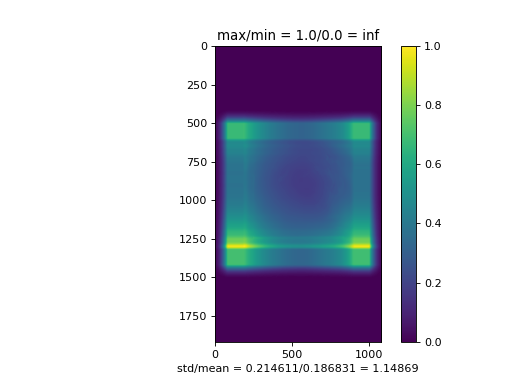

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


In [13]:
import joblib
maskPath = saveDataPath
maskName = "phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl"
mask_str = "onsite"
# maskName = "blk600x600_antiatt_phone_mask_raw_0911_142600.bmp"
# mask_str = "rawmask"
phone_mask = joblib.load(saveDataPath / maskName)
# if len(mask.shape)==3:
#     mask = mask[:,:,1]
phone_mask
im_maxmin(phone_mask)

In [14]:
expan_r = 5
x_norm_expan = torch.repeat_interleave(torch.ones(28, 28), expan_r, dim=0)
x_norm_expan = torch.repeat_interleave(x_norm_expan, expan_r, dim=1)
x_norm_embedded = CenterEmbedding(x_norm_expan, torch.zeros(1920, 1080))
sub_phone_mask = phone_mask * x_norm_embedded.numpy()
sub_phone_mask = sub_phone_mask / sub_phone_mask.max()
plt.figure()
plt.imshow(sub_phone_mask)
plt.show()

NameError: name 'CenterEmbedding' is not defined

# Definition of the Neural Network

In [15]:
""" Define digitized fully connected layers """

# Definition of an in-place digitization function.
def Digitize(tensor, quant_mode='det', levels=16, min_val=None, max_val=None):
    if not min_val and not max_val:
        min_val, max_val = tensor.min().item(), tensor.max().item()
    tensor.clamp_(min_val, max_val).add_(-1*min_val).mul_(levels-1).div_(max_val-min_val)
    if quant_mode == "det": 
        tensor.round_()
    elif quant_mode == "rand":
        tensor.add_(torch.rand(tensor.size(), device=tensor.device).add_(-0.5)).round_()
    tensor.mul_(max_val-min_val).div_(levels-1).add_(min_val)
    return tensor

class DigitizeLinear(nn.Linear):

    def __init__(self,  *kargs, a_quant_mode="det", w_quant_mode="det", a_quant_levels=16, w_quant_levels=32, running_weight=0.001, **kwargs):
        super(DigitizeLinear, self).__init__(*kargs, **kwargs)
        self.act_quant_mode = a_quant_mode
        self.weight_quant_mode = w_quant_mode
        self.register_buffer("act_quant_levels", torch.tensor(a_quant_levels))
        self.register_buffer("weight_quant_levels", torch.tensor(w_quant_levels))
        self.register_buffer("running_weight", torch.tensor(running_weight)) 
        self.register_buffer("running_min", None)
        self.register_buffer("running_max", None)

    def forward(self, input):

        if not self.weight_quant_mode is None: # Set a flag to control weight digitization.
            if not hasattr(self.weight,'org'):
                self.weight.org=self.weight.data.clone()
            self.weight.data=Digitize(self.weight.data, quant_mode=self.weight_quant_mode, levels=self.weight_quant_levels)

        if not self.bias is None:
            self.bias.org=self.bias.data.clone()    
        out = nn.functional.linear(input, self.weight, bias=self.bias)

        if not self.act_quant_mode is None: # A flag to control output digitization. 
            if self.training: # Update the running average of min and max only during training
                with torch.no_grad():
                    if not self.running_min and not self.running_max:
                        self.running_min, self.running_max = out.min(), out.max()
                    self.running_min = (1-self.running_weight) * self.running_min + self.running_weight * out.min()
                    self.running_max = (1-self.running_weight) * self.running_max + self.running_weight * out.max()
            out.data=Digitize(out.data, quant_mode=self.act_quant_mode, levels=self.act_quant_levels, min_val=self.running_min, max_val=self.running_max)
    
        return out

In [16]:
""" Define a generic QAT MLP structure (including perceptron) """

class Net(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([DigitizeLinear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X
    
    def set_digitize_config(self, a_quant_mode, w_quant_mode, a_quant_levels, w_quant_levels):
        for fc in self.fcs:
            fc.act_quant_mode = a_quant_mode
            fc.weight_quant_mode = w_quant_mode
            fc.act_quant_levels = torch.tensor(a_quant_levels)
            fc.weight_quant_levels = torch.tensor(w_quant_levels)

In [17]:
""" Load the trained model """

device = "cpu"

model = Net([784, 100, 100, 10])
for l in model.fcs:
    l.running_min = torch.tensor(0.0)
    l.running_max = torch.tensor(0.0)
model_ckpt = torch.load("./RA_4bit_H2_100_100_lr_0.043_0.50_m_0.87_wep_6_randActDigi_v80_ep97.pt", map_location=device)
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

Net(
  (fcs): ModuleList(
    (0): DigitizeLinear(in_features=784, out_features=100, bias=True)
    (1): DigitizeLinear(in_features=100, out_features=100, bias=True)
    (2): DigitizeLinear(in_features=100, out_features=10, bias=True)
  )
)

In [18]:
""" Construct dataloaders """

trainID_range = range(200) # ID of the samples to be passed through the NN

# Import the test data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if True else {}

data_mnist_test = datasets.MNIST('../ML_data', 
                                 train=False, 
                                 transform=transforms.Compose([transforms.ToTensor()]))

# Remember to set the batch size to the length of train ID range, or the dataloader will draw sample one by one.
subset_data_loader = torch.utils.data.DataLoader(data_mnist_test, 
                                           batch_size=int(max(trainID_range)+1), 
                                           shuffle=False, **kwargs)

# Remember to set the batch size to the length of train ID range, or the dataloader will draw sample one by one.
test_loader = torch.utils.data.DataLoader(data_mnist_test, 
                                           batch_size=1, 
                                           shuffle=False,  **kwargs)

# Notes on ONN Forward Propagation Implementation (Rev. 3)

The update equation from one neuron layer to the next:

\begin{equation}
x_{i}^{L+1} = \sigma(\sum_{j}^N{W_{ij}^{L} x_{j}^{L}+b_i^{L}})    
\end{equation}

where $x_j^L$ is the activation of neuron $j$ in layer $L=0,1,..$.

Since the pixel values in an ONN are intensity encoded, including inputs, activations, and weights, the update equation needs to be modified such that the matrices and vectors to be loaded onto the ONN contain only non-negative numbers. In fact, the possible range of matrix and vector entries is actually limited to positive values, since the phone and SLM pixel values cannot infinitely approach zero in reality, due to hardware limitations. The following framework deals with the most general case where both phone and SLM pixel values cannot be extinguished to zero. If reality, if the resolution permits, the expression can be significantly simplified if either phone or SLM pixels can reach zero within the demanded accuracy.

The update equation is first rewritten into a vector form to facilitate the following discussion:

\begin{equation}
X^{L+1} = \sigma({W^{L} X^{L} + B^{L}})    
\end{equation}

A note on symbol convention: any lower case letter represents a column vector (e.g., $b$, $x$); any captital letter represents a matrix (e.g., $W$, and $X$ actually indicates a batch of data $X = [x_0, x_1, ..., x_{B-1}]$); columns and rows of a matrix is represented in Python indexing convention (i.e., $W[,j]$ and $W[i,]$); element at row $i$ and column $j$ of matrix $W$ is written as $W[i,j]$ instead of $W_{ij}$; the $i$th element in vector a vector is also indicated with Python indexing convention (e.g., $x[i]$ instead of $x_i$). The superscript $L$ indicating the layer of NN is dropped here and below as long as it does not cause any confusion. 

Therefore, $W^L[i,j]$ is the weight from neuron i in layer L to neuron j in layer L+1, $X^L[j,k]$ is the actication of neuron j of data batch index k, $B^L[i,k]$ is the bias for neuron i in layer L.

Each element in a row $W[i,]$ can be linearly mapped from interval $[\text{min}(W[i,]), \text{max}(W[i,])]$ to $[I_\text{min}, I_\text{max}]$, with $I_\text{max}>I_\text{min} \geq 0$. More explicitely, the resultant matrix $\tilde{W}$ is related to $W$ with the relation:

\begin{equation}
W = \hat{K}\tilde{W} + \hat{D}\mathbb{1}
\end{equation}

where
\begin{equation}
\hat{K}=\frac{1}{I_\text{max}-I_\text{min}}diag\{\Delta W_i = \text{max}(W[i,]) - \text{min}(W[i,])\}, 
\hat{D} = \frac{1}{I_\text{max}-I_\text{min}} diag \{I_\text{max} \text{min}(W[i,]) - I_\text{min} \text{max}(W[i,]) \}
\end{equation}
and $\mathbb{1}$ is all 1 matrix. (Tip: hat implies diagonal matrix; tilde implies the control signal to be sent to a device, such as phone or SLM).


The same transform can be performed on a data batch, which gives $X = \tilde{X} \hat{K}_X  +  \mathbb{1}\hat{D}_X$ ($\hat{K}_X$ and $X$ switch position because the definiation of $X$ is transposed from that of $W$.)

Now we can rewrite the update equation as
\begin{equation}
X^{L+1}  = \sigma( \hat{K}  \{\tilde{W} \tilde{X}^L\} \hat{K}_X  + \hat{D} \{\mathbb{1} \tilde{X}^L\} \hat{K}_X  + \hat{K} \{\tilde{W}\mathbb{1}\}\hat{D}_X + \hat{D} \mathbb{1}\mathbb{1} \hat{D}_X + b)
\end{equation}


Note that the matrix products in curly brackets are to be measured expiermentally from the ONN output, and the other quantities are computed once and stored.


The reason to rewrite the update equation in this form is to carry out *each* inner product computation at the full pixel resolution of the smartphone and SLM. The matrices and vectors are always normalized to cover the entire dynamic range of the devices. The normalization factor is stored and later re-applied to the value readout from the ONN to recover the actual numerical value. 


More specifically, the passing of NN activation from one layer to the next can be summarized as the following steps:
1. Normalize $W$ to $\tilde{W}$, which needs to be done only once for a trained NN and takes $O(MN)$ operations. 
2. Normalize $X$ to $\tilde{X}$, which needs to be done for every input and layer and takes a total of $NBL$ multiplications. However, these operations can be waived if the phone pixel has high enough bit depth. Since the activations are usually non-negative numbers, it is possible to represent them with pixel intensity without any pre-processing.
3. Load $\tilde{X}$ to the phone to control pixel intensity and $\tilde{W}$ to SLM to control transimission. In this way, $\tilde{W}$ and $\tilde{X}$ are both represented with the full resolutin of the devices.
4. Measure the total pixel value in a region of interest that corresponds to the inner product $\tilde{W}[i,]\tilde{X}[,j]$ (read: the input to neuron $i$ for the data batch index $j$) in the captured camera image. In the ideal case, this signal can be measured by a single-pixel detector.
5. Use the calibration model to find $\tilde{W}[i,]\tilde{X}[,j]$ based on the integrated pixel value in the regions of interest, obtained in step (4). 
6. After reading out all the entries of $\tilde{W}\tilde{X}$ (W_til_X_til), multiply it with $\hat{D}$ and $\hat{D_X}$ digitially, which were obtained in step (1) and (2).
7. Derive $\mathbb{1} \tilde{X}$ (sum_X_til) and $\tilde{W}\mathbb{1}$ (sum_W_til) following similar steps as (5) and (6). Essentially they are just special cases of $\tilde{W}\tilde{X}$ with either $\tilde{W} = \mathbb{1}$ or $\tilde{X} = \mathbb{1}$.
8. Add the computed terms $\hat{K}\tilde{W}\tilde{X}\hat{K}_X$ (Delta_W_Delta_X), $\hat{D}\mathbb{1}\tilde{X}\hat{K}_X$ (Offset_W_Delta_X),  $\hat{K}\tilde{W}\mathbb{1}\hat{D}_X$ (Delta_W_Offset_X), $\hat{D} \mathbb{1}\mathbb{1}\hat{D}_X$ (Offset_W_Offset_X), and $b$ digitally, and then apply the nonlinear activation function $\sigma$ to obtain the activations of neurons.



In [19]:
"""Auxilitary functions for simulating activation propation in ONN"""

def digitize(x, levels=8, min_val=None, max_val=None):
    """
    digitize activations into the discrete steps, by rounding to the closest level.
    levels: specifies the number of total discrete levels.
    min_val: the x value to be mapped to the lowest level
    max_val: the x value to be mapped to the highest level
    """

    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()
    x = (levels-1)*(x - min_val)/(max_val-min_val)
    x = x.round()
    x = torch.min(torch.max(x, torch.zeros_like(x)), torch.ones_like(x)*(levels-1))
    x = x*(max_val-min_val)/(levels-1) + min_val
    return x

def Matrix_Linear_Mapping(W, target_interval):
    """
    Transform each column of W with the following linear transform: 
    Argument target_interval=[a,b] specifies the lower and upper bound a and b.
    The minimum of each column of W will be mapped to a, and the maximum of each W column mapped to b.
    The rest of elements in the column are mapped in-between a and b with linear interporlation.
    Such operation is repeated for each column individually.
    """
    
    W = W.type(torch.double)
    W_mins, _ = torch.min(W, dim=0) 
    W_maxs, _ = torch.max(W, dim=0)
    Delta_I = float(target_interval[1] - target_interval[0])
    Delta_W = W_maxs - W_mins
    K_W = torch.diag(Delta_W/Delta_I)
    D_W = target_interval[1]*W_mins - target_interval[0]*W_maxs
    offset = torch.mm(torch.repeat_interleave(D_W.view(1,-1), W.shape[0],dim=0), torch.diag(1/Delta_W))
    W_til = torch.mm(W, torch.diag(Delta_I/Delta_W)) - offset
    
    return (W_til, K_W, torch.diag(D_W)/Delta_I)
    

def ONN_layer_prop(layer, W_transform, X_transform, W_digitize_func=None, X_digitize_func=None, Act_digitize_func=None,  X=None,
                     W_til_X_til=None, sum_W_til=None, sum_X_til=None):
    """
    Forward propagate a batch of data for one layer.

    layer: of type torch.nn.module, the layer to propagate the current batch of data through. Both W and b are derived from layer.
    W_transform: the mapping from the W stored in layer to the control value to be applied to SLM.
    X_transform: the mapping from the activation values stored in X to the control value to be applied to the smartphone.
    Act_digitize_func: The function for digitizing the output activation. No digitization is performed if None is given.
    W_digitize_func: The function for digitizing weight matrix W before the forward propagation. 
                     No digitization is performed if None is assigned to W_digitize_func as default.
    X_digitize_func: The function for digitizing the batch data X before the forward propagation. 
                     No digitization is performed if None is assigned to X_digitize_func as default.
    X: Inputs to the current NN layer. 
       If X is not given, an identity matrix is assigned to X as default, such that the W_til_X_til returned by the function equals W_til.
       X.shape = [batch size, current NN layer width]
    W: weight matrix derived from layer. W.shape = [current NN layer width, next NN layer size]
    b: bias vector. b.shape = [next NN layer width]
    
    When no digitization is performed on W, X, or Wx+b, only linear stretching is performed on W and X, and the output of the function is 
    almost identical to the results obtained by prop(layer).
    """
    
    W = layer.weight.data.t()
        
    # Normalize W 
    (W_til, K_W, D_W) = W_transform(W)
    
    if X is None: # If X is not given, make it an identity matrix.
        X = torch.eye(W.shape[0])
        (X_til, K_X, D_X) = Matrix_Linear_Mapping(X, [0,1])
    else: # Normalize X
        (X_til, K_X, D_X) = X_transform(X.t())
        (X_til, K_X, D_X) = (X_til.t(), K_X.t(), D_X.t())
    
    if W_digitize_func is not None:
        W_til = W_digitize_func(W_til)
        
    if X_digitize_func is not None:
        X_til = X_digitize_func(X_til)
        
    W_til_max = W_til[:,0].max()
    X_til_max = X_til[0,:].max()
    
    # First simulate the three measurables from the ONN (defined in Notes on ONN Forward Propagation Implementation (Rev. 3)):
    if W_til_X_til is None:
        W_til_X_til = torch.mm(X_til, W_til) # tilde{WX} 
    if sum_X_til is None:
        sum_X_til = torch.mm(X_til, torch.ones_like(W_til)) * W_til_max # sum(tilde{X[j,:]}), aka the sum of all activations of batch index j.   
    if sum_W_til is None:
        sum_W_til = torch.mm(torch.ones_like(X_til), W_til) * X_til_max# sum(tilde{W[:,i]}), aka the sum of all weights into neuron i.
    
    # The following terms are defined in Notes on ONN Forward Propagation Implementation (Rev. 3)
    Delta_W_Delta_X = torch.mm(torch.mm(K_X, W_til_X_til), K_W) 
    Delta_W_Offest_X = torch.mm(torch.mm(K_X, sum_X_til), D_W) / W_til_max
    Offset_W_Delta_X = torch.mm(D_X, torch.mm(sum_W_til, K_W)) / X_til_max
    Offset_W_Offset_X = torch.mm(D_X, torch.mm(torch.ones_like(W_til_X_til)*W_til.shape[0], D_W)) 
    
    Wx = Delta_W_Delta_X + Delta_W_Offest_X + Offset_W_Delta_X + Offset_W_Offset_X  # Wx
    Wx_b = Wx + torch.repeat_interleave(layer.bias.view(1,-1), W_til_X_til.shape[0], dim=0).type(torch.double) # Wx+b
    if Act_digitize_func is not None:
        Wx_b = Act_digitize_func(Wx_b) # digitize(Wx+b)
    a = F.relu(Wx_b) # ReLU(digitize(Wx+b))

    return {"norm(W)norm(X)": W_til_X_til, "sum(norm(X))": sum_X_til, "sum(norm(W))": sum_W_til, "Wx": Wx, "Wx+b": Wx_b, "a": a}

In [20]:
# Calculate the ground truth of activations of each layer 
# by Propagating each test sample through the trained NN and record activation of each layer.
import pandas

X, data_labels = next(iter(subset_data_loader))
X = X.view(X.size(0), -1)
X0 = X

df_layer = {}

# Define the transform and quantization functions for all layers:
W_transform = lambda W: Matrix_Linear_Mapping(W, [5,2**8-1])
X_transform = lambda X: Matrix_Linear_Mapping(X, [0,1000-1])
W_digitize = lambda W: Digitize(W.clone(), levels=2**8-5) # levels of quantization for W
X_digitize = lambda X: Digitize(X.clone(), levels=1000) # levels of quantization for X
# One very strange thing is that you cannot lambda function dictionary

for l, layer in enumerate(model.fcs):
    # Calculate the ground truth activation by passing through one layer
    layer.act_quant_mode=None
    layer.weight_quant_mode=None
    X0 = F.relu(layer(X0))
    
    # Propagate the batch for one layer
    Act_digitize = lambda X: Digitize(X.clone(), levels=2**4, min_val=layer.running_min.item(), max_val=layer.running_max.item()) # levels of quantization for y=Wx+b
    results = ONN_layer_prop(layer, W_transform, X_transform, \
                             W_digitize_func=W_digitize, X_digitize_func=X_digitize, Act_digitize_func=Act_digitize, X=X)    
    X = results["a"] # The activation of the current layer is the input to the next layer. 
    
    results["a_true"] = X0
    df = {}
    for k in results.keys():
        df[k] = pandas.DataFrame(results[k].detach().numpy()).stack(level=-1)
    df_layer[l] = pandas.concat(df, axis=1)
        
# Concatenate the df for each sample into an even larger one to include all the samples spcified.    
df_all_acts = pandas.concat(df_layer, axis=0, \
                            keys=df_layer.keys(), names=["layer", "test_ID", "output node"])
df_all_acts.index = df_all_acts.index.swaplevel(0,1)

In [21]:
df_all_acts

norm(W)norm(X)  sum(norm(X))  sum(norm(W))  \
test_ID layer output node                                               
0       0     0                 7435548.0    18435480.0   101575323.0   
              1                 9019478.0    18435480.0    99886014.0   
              2                 9160499.0    18435480.0    95635269.0   
              3                 9690888.0    18435480.0   101176722.0   
              4                11035015.0    18435480.0    94579326.0   
...                                   ...           ...           ...   
199     2     5                  596998.0     2243745.0    10846143.0   
              6                  604275.0     2243745.0     9649341.0   
              7                 1273638.0     2243745.0    10318671.0   
              8                 1021207.0     2243745.0    12271716.0   
              9                  682060.0     2243745.0    11444544.0   

                                   Wx        Wx+b          a      a_true  
test_ID layer output node                                                 
0       0     0            -15.719175  -15.587848   0.000000    0.000000  
              1             -3.035051   -1.576992   0.000000    0.000000  
              2             -1.905754   -1.576992   0.000000    0.000000  
              3              2.341606    5.428436   5.428436    2.607136  
              4             13.105385   12.433863  12.433863   12.107492  
...                               ...         ...        ...         ...  
199     2     5           -502.093804 -515.057654   0.000000    0.000000  
              6           -495.412649 -515.057654   0.000000    0.000000  
              7            119.142521   94.972668  94.972668  101.693199  
              8           -112.619283 -108.370772   0.000000    0.000000  
              9           -423.996730 -413.385933   0.000000    0.000000  

[42000 rows x 7 columns]

In [22]:
print(data_labels[50])
df_all_acts.loc[(50,0)]

tensor(6)


C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  


,norm(W)norm(X),sum(norm(X)),sum(norm(W)),Wx,Wx+b,a,a_true
output node,,,,,,,
0,10328027.0,20142450.0,101575323.0,0.475091,-1.576992,0.000000,0.000000
1,10031575.0,20142450.0,99886014.0,-1.898899,-1.576992,0.000000,0.000000
2,11218257.0,20142450.0,95635269.0,7.604060,5.428436,5.428436,6.597994
3,11818030.0,20142450.0,101176722.0,12.407047,12.433863,12.433863,12.708588
4,9299017.0,20142450.0,94579326.0,-7.765229,-8.582420,0.000000,0.000000
...,...,...,...,...,...,...,...
95,8049976.0,20142450.0,105060834.0,-17.767560,-15.587848,0.000000,0.000000
96,9271061.0,20142450.0,97347555.0,-7.989101,-8.582420,0.000000,0.000000
97,10241632.0,20142450.0,106398495.0,-0.216761,-1.576992,0.000000,0.000000


# Generate Phone and SLM Images

In [23]:
L = 2
if L > 0:
    df_hidden_layers = {}
    for l in range(L):
        df_hidden_layers[l] = pandas.read_hdf((resultPath / f"fc{l}_acts_ID_130_to_200_float_2pcts.h5").as_posix(), f"fc{l}_acts")
    
df_measured_acts = pandas.concat(df_hidden_layers, axis=0, \
                            keys=df_hidden_layers.keys(), names=["layer", "test_ID", "output node"])
df_measured_acts.index = df_measured_acts.index.swaplevel(0,1)
df_measured_acts

fcs.0.sim  ground_truth  fcs.0   fcs.1.sim  fcs.1
test_ID layer output node                                                   
130     0     0            -2.323618     -1.576992    0.0         NaN    NaN
              1            -8.439739     -8.582420    0.0         NaN    NaN
              2            -2.559680     -1.576992    0.0         NaN    NaN
              3            -4.687803     -1.576992    0.0         NaN    NaN
              4            -0.305664     -1.576992    0.0         NaN    NaN
...                              ...           ...    ...         ...    ...
199     1     95                 NaN   -184.172670    NaN -254.880539    0.0
              96                 NaN   -150.970133    NaN -230.141769    0.0
              97                 NaN    -18.159985    NaN -109.593086    0.0
              98                 NaN     15.042552    NaN  -33.087898    0.0
              99                 NaN   -150.970133    NaN -192.134460    0.0

[14000 rows x 5 columns]

The normalized weight matrix to be applied on the SLM looks like below:


<IPython.core.display.Javascript object>


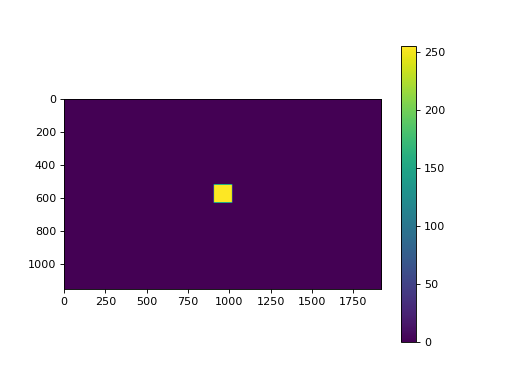

In [24]:
""" Generate the weight images to be applied to SLM and save them. """
# Pre-process the SLM weight matrix by shifting all elements to non-negative.

import numpy as np
from utils.helper_functions import ConvertPhoneImageToSLMImage, NormalizeWeights, CenterEmbedding

# Indicate the current NN layer (the 1st layer has index 0)
expan_r = 9+2

# Convert weight matrix to SLM control values using EXACTLY the same sequence of functions as in ONN_layer_prop()
W = model.fcs[L].weight.data.t()
W_til,_,_ = W_transform(W)
W_norm = W_digitize(W_til).t()
W_norm = W_norm.round().type(torch.uint8)
blkIdx = Wrap_vec_to_square(torch.tensor(df_measured_acts.index.get_level_values(level="output node").unique().values))

slm_weights_numpy = {}

for i in range(W_norm.size(0)):
    # Add a frame for alignment, and embed in a canvas of phone display size
    w_norm_orig = torch.cat((W_norm[i,:],torch.tensor([0])))[blkIdx]
    w_norm_expan = torch.repeat_interleave(w_norm_orig, expan_r, dim=0)
    w_norm_expan = torch.repeat_interleave(w_norm_expan, expan_r, dim=1)
    w_norm_embedded = CenterEmbedding(w_norm_expan, torch.zeros(1920, 1080, dtype=torch.uint8))
    w_norm_slm = ConvertPhoneImageToSLMImage(w_norm_embedded, 1.0) # Convert the phone image to SLM image.

    # Save the SLM patterns to image files.
    w_norm_path = slmWeightPath / (f"SLM_MLP_{expan_r}x_fc{L}_w{i}.bmp")
    w_norm_slm.save(w_norm_path.as_posix(), format = 'bmp') # PIL.Image.save can be saved as 8-bit greyscale bmp
    
w_norm_embedded = CenterEmbedding(torch.ones_like(w_norm_expan)*255, torch.zeros(1920, 1080, dtype=torch.uint8))
w_norm_slm = ConvertPhoneImageToSLMImage(w_norm_embedded, 1.0) # Convert the phone image to SLM image.

# Save the SLM patterns to image files.
w_norm_path = slmWeightPath / (f"SLM_MLP_{expan_r}x_fc{L}_wsum.bmp")
w_norm_slm.save(w_norm_path.as_posix(), format = 'bmp') # PIL.Image.save can be saved as 8-bit greyscale bmp
    
# Plot w_kaleidoscope 
print("The normalized weight matrix to be applied on the SLM looks like below:")
fig, ax = plt.subplots()
im = ax.imshow(w_norm_slm)
fig.colorbar(im, ax=ax)
plt.show()

The normalized weight matrix to be applied on the SLM looks like below:


<IPython.core.display.Javascript object>


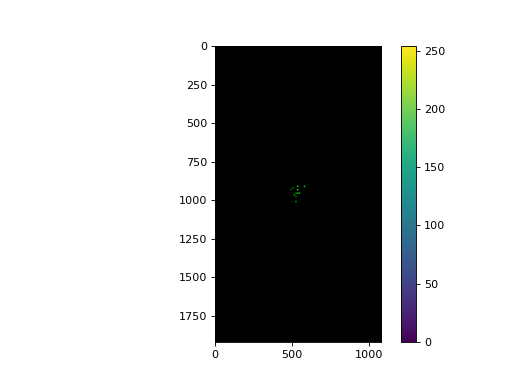

In [25]:
""" Generate the images to be displayed on the phone and save them. """

input_data, data_labels = next(iter(subset_data_loader))
input_data = input_data.view(X.size(0), -1)

subPath = phoneImagePath /  (f"fc{L}_2pcts" )
if not os.path.exists(subPath.as_posix()):
    os.makedirs(subPath.as_posix())

px_margin = 1
blankImage = torch.zeros(3, 1920, 1080, dtype=torch.uint8)

for i, batchIdx in enumerate(range(130, 200)):
    
    # x is the output of the previous layer L-1 (L>0) or the input data (L==0).
    if L > 0:
        x = torch.tensor(df_measured_acts["fcs.1"].loc[batchIdx, L-1, :].values)
        #x = torch.tensor(df_all_acts["a_true"].loc[batchIdx, L-1, :].values) # test mode
    elif L == 0:
        x = input_data[batchIdx,:]
    
    # Normalize each x to its max and min and scale to 7 bit to match the dynamical range of the phone.
    # The operations here are performed EXACTLY the same as in ONN_layer_prop()
    x_til,_,_ = X_transform(x.view(-1,1))
    x_norm = X_digitize(x_til.squeeze()).round().type(torch.long) # round() cannot be omitted for type(torch.long) sometimes work as floor(0)
    
    # Add the singla-pixel frame for image alignment.
    imToPhone = blankImage.clone()
    x_norm_orig = torch.cat((x_norm,torch.tensor([0])))[blkIdx]
    x_norm_expan = torch.repeat_interleave(x_norm_orig, expan_r, dim=0)
    x_norm_expan = torch.repeat_interleave(x_norm_expan, expan_r, dim=1)
    x_norm_spar = x_norm_expan
    x_norm_spar[::expan_r,:] = 0
    x_norm_spar[(expan_r-px_margin)::expan_r,:] = 0
    x_norm_spar[:,::expan_r] = 0
    x_norm_spar[:,(expan_r-px_margin)::expan_r] = 0
    x_norm_embedded = CenterEmbedding(x_norm_spar, blankImage[1,:,:].type(torch.long))
    imToPhone[1, :, :] = lut_p[x_norm_embedded.type(torch.long)] # no uniformness correction
    #phone_corr_numpy = lut_p[(x_norm_embedded * sub_phone_mask).type(torch.long)]
    #imToPhone[1, :, :] = phone_corr_numpy

    # Save the generated image
    imToPhone_PIL = transforms.ToPILImage()(imToPhone)
    imToPhone_PIL.save((subPath / f"test_{expan_r}x_gap2px_MLP_2pcts_fc{L}_digit_{data_labels[batchIdx]}_{batchIdx:05d}.png").as_posix())

# Generate and save a black image to be displayed on the phone for background and power saving.
blackImage_PIL = transforms.ToPILImage()(blankImage)
blackImage_PIL.save((phoneImagePath / "black.png").as_posix())

print("The normalized weight matrix to be applied on the SLM looks like below:")
fig, ax = plt.subplots()
im = ax.imshow(imToPhone_PIL)
fig.colorbar(im, ax=ax)
plt.show()

In [26]:
ConvertPhoneImageToSLMImage(imToPhone[1,:,:], 1.0).save((slmWeightPath / "alignment_check").as_posix(), format = 'bmp')

# Acquire Data

In [26]:
""" Set up MPPC experiment scheme. """

repeats = 100
oscope.set_range(6)
oscope.set_offset(2)
oscope_info(oscope)

{'ID': 'HEWLETT-PACKARD,54845A,US40240103,A.04.50\n',
 'x_range': 0.0001,
 'x_unit': 'SECOND',
 'y_range': 6.0,
 'y_unit': 'VOLT',
 'y_offset': 2.0,
 'y_bounds': [-1.0, 5.0]}

In [27]:
""" Set up the (empty) dataframe table for taking data. """

import pandas

repeats = 100
test_digit_idx = np.arange(200)
node_idx = [*range(10), "sum", "bkg"]
time_ranges = [0.0001, ]
#rowMultiIdx = pandas.MultiIndex.from_product([test_digit_idx, node_idx, time_ranges, np.arange(repeats)], names=["test_ID", "output_node", "time_range", "repeats"])
rowMultiIdx = pandas.MultiIndex.from_product([node_idx, time_ranges, np.arange(repeats)], names=["output_node", "time_range", "repeats"])
#df_volTraces = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

phoneLoadPath = subPath 
slmLoadPath = slmWeightPath 

print(phoneLoadPath)
print(slmLoadPath)
print(rowMultiIdx)
#print(df_volTraces)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\phone_images\fc2_2pcts
D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\slm_weights
MultiIndex([(    0, 0.0001,  0),
            (    0, 0.0001,  1),
            (    0, 0.0001,  2),
            (    0, 0.0001,  3),
            (    0, 0.0001,  4),
            (    0, 0.0001,  5),
            (    0, 0.0001,  6),
            (    0, 0.0001,  7),
            (    0, 0.0001,  8),
            (    0, 0.0001,  9),
            ...
            ('bkg', 0.0001, 90),
            ('bkg', 0.0001, 91),
            ('bkg', 0.0001, 92),
            ('bkg', 0.0001, 93),
            ('bkg', 0.0001, 94),
            ('bkg', 0.0001, 95),
            ('bkg', 0.0001, 96),
            ('bkg', 0.0001, 97),
            ('bkg', 0.0001, 98),
            ('bkg', 0.0001, 99)],
           names=['output_node', 'time_range', 'repeats'], length=1200)


In [28]:
""" Perform the inference of the trained model with ONN on test digits, and save the data. """

import joblib, pickle, time

exp_time = datetime.now()
savePath = resultPath /  (f"MLP_fc{L}_{expan_r}x_marg_1px_2pcts_MPPC_{exp_time:%m%d_%H%M%S}")
print(savePath)
if not os.path.exists(savePath.as_posix()):
    os.makedirs(savePath.as_posix())

oscope.instrument.write("TIM:RANG 0.0001")

joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')
dataFile = pandas.HDFStore((savePath / "mppc_vol_meas.h5").as_posix())

# write a black image to the phone to take the background
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)

for idx in range(130, 200):
#for idx in range(20):
    t0 = time.time()
    # Record background to capture potential voltage bias drift
    aoab.write(blackImage_byte)
    #time.sleep(0.5)
    slmPattern_PIL = Image.open((slmLoadPath / f"SLM_solid_0.bmp").as_posix())
    slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
    time.sleep(0.5)
    
    df = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

    for i in rowMultiIdx.get_level_values("repeats").unique(): 
        trace = oscope.get_waveform()
        df.loc[("bkg", 0.0001, i), range(len(trace))] = trace
        time.sleep(0.04)
    print(f"time_span=0.0001s, test_ID={idx}, label={data_labels[idx]}, output_node=bkg, voltage={trace.mean()}")
        
    # Load the phone pattern
    phonePattern_PIL = Image.open((phoneLoadPath / f"test_{expan_r}x_gap2px_MLP_2pcts_fc{L}_digit_{data_labels[idx]}_{idx:05d}.png").as_posix())
    phonePattern_byte = PIL_to_bytestream(phonePattern_PIL)
    aoab.write(phonePattern_byte)
    time.sleep(0.5) # Wait for the pattern applied to be stable
    for n in rowMultiIdx.get_level_values("output_node").unique().drop("bkg"):
        # refresh the slm pattern
        slmPattern_PIL = Image.open((slmLoadPath / f"SLM_MLP_{expan_r}x_fc{L}_w{n}.bmp").as_posix())
        slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
        time.sleep(0.5) # Wait for the pattern applied to be stable
        
        for i in rowMultiIdx.get_level_values("repeats").unique(): 
            trace = oscope.get_waveform()
            df.loc[(n, 0.0001, i), range(len(trace))] = trace
            time.sleep(0.04)
        print(f"time_span=0.0001s, test_ID={idx}, label={data_labels[idx]}, output_node={n}, voltage={trace.mean()}")
            
        if n == 9 and idx == 1:
            print("20 s to exit anydesk")
            time.sleep(20)  
            
    t1 = time.time()
    print(f"Time consumed for 1 sample = {t1-t0} s")
    t0 = t1
    dataFile[str(idx)]=df 
    
dataFile.close()
print("Finished! Safe to change code now.")

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\12_01_20_4bit_randy_aug_MLP_100_100_MPPC\MLP_fc2_11x_marg_1px_2pcts_MPPC_1227_114053


C:\Users\Logan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2878: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


time_span=0.0001s, test_ID=130, label=6, output_node=bkg, voltage=-0.006759959738701582
time_span=0.0001s, test_ID=130, label=6, output_node=0, voltage=0.009698206558823586
time_span=0.0001s, test_ID=130, label=6, output_node=1, voltage=0.008337649516761303
time_span=0.0001s, test_ID=130, label=6, output_node=2, voltage=0.006151393987238407
time_span=0.0001s, test_ID=130, label=6, output_node=3, voltage=0.005393426399677992
time_span=0.0001s, test_ID=130, label=6, output_node=4, voltage=0.006217130925506353
time_span=0.0001s, test_ID=130, label=6, output_node=5, voltage=0.012744024395942688
time_span=0.0001s, test_ID=130, label=6, output_node=6, voltage=0.017599603161215782
time_span=0.0001s, test_ID=130, label=6, output_node=7, voltage=0.005928286351263523
time_span=0.0001s, test_ID=130, label=6, output_node=8, voltage=0.007575697731226683
time_span=0.0001s, test_ID=130, label=6, output_node=9, voltage=0.008573705330491066
time_span=0.0001s, test_ID=130, label=6, output_node=sum, volt

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '130'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Logan\Anaconda3\lib\site-packages\pandas\io\pytables.py:556: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1_level0] [items->None]

  self.put(key, value)
C:\Users\Logan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             994,  995,  996,  997,

time_span=0.0001s, test_ID=131, label=6, output_node=bkg, voltage=-0.003938246984034777
time_span=0.0001s, test_ID=131, label=6, output_node=0, voltage=-0.0023446213454008102
time_span=0.0001s, test_ID=131, label=6, output_node=1, voltage=-0.0008336654282175004
time_span=0.0001s, test_ID=131, label=6, output_node=2, voltage=-0.001630478072911501
time_span=0.0001s, test_ID=131, label=6, output_node=3, voltage=-0.0011503985151648521
time_span=0.0001s, test_ID=131, label=6, output_node=4, voltage=-6.474096153397113e-05
time_span=0.0001s, test_ID=131, label=6, output_node=5, voltage=0.0018914343090727925
time_span=0.0001s, test_ID=131, label=6, output_node=6, voltage=0.002392430556938052
time_span=0.0001s, test_ID=131, label=6, output_node=7, voltage=-0.0048177288845181465
time_span=0.0001s, test_ID=131, label=6, output_node=8, voltage=9.760964167071506e-05
time_span=0.0001s, test_ID=131, label=6, output_node=9, voltage=-0.001352589693851769
time_span=0.0001s, test_ID=131, label=6, output_

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '131'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=132, label=5, output_node=bkg, voltage=-0.0066533866338431835
time_span=0.0001s, test_ID=132, label=5, output_node=0, voltage=0.00467529846355319
time_span=0.0001s, test_ID=132, label=5, output_node=1, voltage=0.006450199522078037
time_span=0.0001s, test_ID=132, label=5, output_node=2, voltage=0.007951195351779461
time_span=0.0001s, test_ID=132, label=5, output_node=3, voltage=0.010574700310826302
time_span=0.0001s, test_ID=132, label=5, output_node=4, voltage=0.0027260957285761833
time_span=0.0001s, test_ID=132, label=5, output_node=5, voltage=0.017033865675330162
time_span=0.0001s, test_ID=132, label=5, output_node=6, voltage=0.006096613127738237
time_span=0.0001s, test_ID=132, label=5, output_node=7, voltage=0.001071713282726705
time_span=0.0001s, test_ID=132, label=5, output_node=8, voltage=0.009194224141538143
time_span=0.0001s, test_ID=132, label=5, output_node=9, voltage=0.009290837682783604
time_span=0.0001s, test_ID=132, label=5, output_node=sum, vol

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '132'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=133, label=7, output_node=bkg, voltage=-0.006266932003200054
time_span=0.0001s, test_ID=133, label=7, output_node=0, voltage=-0.004433267284184694
time_span=0.0001s, test_ID=133, label=7, output_node=1, voltage=-0.0018266933038830757
time_span=0.0001s, test_ID=133, label=7, output_node=2, voltage=-0.0026125500444322824
time_span=0.0001s, test_ID=133, label=7, output_node=3, voltage=-0.001928286743350327
time_span=0.0001s, test_ID=133, label=7, output_node=4, voltage=-0.003130478085950017
time_span=0.0001s, test_ID=133, label=7, output_node=5, voltage=-0.003263944061473012
time_span=0.0001s, test_ID=133, label=7, output_node=6, voltage=-0.00198406376875937
time_span=0.0001s, test_ID=133, label=7, output_node=7, voltage=0.0025816732086241245
time_span=0.0001s, test_ID=133, label=7, output_node=8, voltage=-0.001129482057876885
time_span=0.0001s, test_ID=133, label=7, output_node=9, voltage=-0.0015717130154371262
time_span=0.0001s, test_ID=133, label=7, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '133'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=134, label=8, output_node=bkg, voltage=-0.007063745055347681
time_span=0.0001s, test_ID=134, label=8, output_node=0, voltage=0.005311753135174513
time_span=0.0001s, test_ID=134, label=8, output_node=1, voltage=0.005389442201703787
time_span=0.0001s, test_ID=134, label=8, output_node=2, voltage=0.006261952221393585
time_span=0.0001s, test_ID=134, label=8, output_node=3, voltage=0.007845617830753326
time_span=0.0001s, test_ID=134, label=8, output_node=4, voltage=0.005796812474727631
time_span=0.0001s, test_ID=134, label=8, output_node=5, voltage=0.005580677650868893
time_span=0.0001s, test_ID=134, label=8, output_node=6, voltage=0.0029103585984557867
time_span=0.0001s, test_ID=134, label=8, output_node=7, voltage=0.0030866533052176237
time_span=0.0001s, test_ID=134, label=8, output_node=8, voltage=0.015442230738699436
time_span=0.0001s, test_ID=134, label=8, output_node=9, voltage=0.008116533979773521
time_span=0.0001s, test_ID=134, label=8, output_node=sum, vo

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '134'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=135, label=1, output_node=bkg, voltage=-0.00618924293667078
time_span=0.0001s, test_ID=135, label=1, output_node=0, voltage=-0.0005667330697178841
time_span=0.0001s, test_ID=135, label=1, output_node=1, voltage=0.006971116177737713
time_span=0.0001s, test_ID=135, label=1, output_node=2, voltage=-0.0001593624911038205
time_span=0.0001s, test_ID=135, label=1, output_node=3, voltage=-0.00042430273606441915
time_span=0.0001s, test_ID=135, label=1, output_node=4, voltage=8.466136205242947e-05
time_span=0.0001s, test_ID=135, label=1, output_node=5, voltage=-0.0018595617730170488
time_span=0.0001s, test_ID=135, label=1, output_node=6, voltage=0.0008167331106960773
time_span=0.0001s, test_ID=135, label=1, output_node=7, voltage=0.003261952195316553
time_span=0.0001s, test_ID=135, label=1, output_node=8, voltage=0.0028814743272960186
time_span=0.0001s, test_ID=135, label=1, output_node=9, voltage=-0.00033067731419578195
time_span=0.0001s, test_ID=135, label=1, output_

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '135'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=136, label=0, output_node=bkg, voltage=-0.005244024097919464
time_span=0.0001s, test_ID=136, label=0, output_node=0, voltage=0.01584761030972004
time_span=0.0001s, test_ID=136, label=0, output_node=1, voltage=0.002083665458485484
time_span=0.0001s, test_ID=136, label=0, output_node=2, voltage=0.005999003536999226
time_span=0.0001s, test_ID=136, label=0, output_node=3, voltage=0.004967131651937962
time_span=0.0001s, test_ID=136, label=0, output_node=4, voltage=0.005882470402866602
time_span=0.0001s, test_ID=136, label=0, output_node=5, voltage=0.008010955527424812
time_span=0.0001s, test_ID=136, label=0, output_node=6, voltage=0.008349601179361343
time_span=0.0001s, test_ID=136, label=0, output_node=7, voltage=0.008463147096335888
time_span=0.0001s, test_ID=136, label=0, output_node=8, voltage=0.005072709172964096
time_span=0.0001s, test_ID=136, label=0, output_node=9, voltage=0.00880079623311758
time_span=0.0001s, test_ID=136, label=0, output_node=sum, voltag

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '136'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=137, label=1, output_node=bkg, voltage=-0.0052260952070355415
time_span=0.0001s, test_ID=137, label=1, output_node=0, voltage=-0.0025268925819545984
time_span=0.0001s, test_ID=137, label=1, output_node=1, voltage=0.008513943292200565
time_span=0.0001s, test_ID=137, label=1, output_node=2, voltage=0.0047051794826984406
time_span=0.0001s, test_ID=137, label=1, output_node=3, voltage=0.0014123505679890513
time_span=0.0001s, test_ID=137, label=1, output_node=4, voltage=-0.001116533880122006
time_span=0.0001s, test_ID=137, label=1, output_node=5, voltage=0.0011972110951319337
time_span=0.0001s, test_ID=137, label=1, output_node=6, voltage=6.673305324511603e-05
time_span=0.0001s, test_ID=137, label=1, output_node=7, voltage=0.0035806773230433464
time_span=0.0001s, test_ID=137, label=1, output_node=8, voltage=0.002546812640503049
time_span=0.0001s, test_ID=137, label=1, output_node=9, voltage=0.000565736903809011
time_span=0.0001s, test_ID=137, label=1, output_node=

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '137'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=138, label=6, output_node=bkg, voltage=-0.006331673823297024
time_span=0.0001s, test_ID=138, label=6, output_node=0, voltage=-0.0013356574345380068
time_span=0.0001s, test_ID=138, label=6, output_node=1, voltage=-0.0005318725598044693
time_span=0.0001s, test_ID=138, label=6, output_node=2, voltage=-0.002659362740814686
time_span=0.0001s, test_ID=138, label=6, output_node=3, voltage=-0.003085657488554716
time_span=0.0001s, test_ID=138, label=6, output_node=4, voltage=-0.0006623505032621324
time_span=0.0001s, test_ID=138, label=6, output_node=5, voltage=-0.0017948206514120102
time_span=0.0001s, test_ID=138, label=6, output_node=6, voltage=0.00232768920250237
time_span=0.0001s, test_ID=138, label=6, output_node=7, voltage=-0.0012948208022862673
time_span=0.0001s, test_ID=138, label=6, output_node=8, voltage=-0.0025129481218755245
time_span=0.0001s, test_ID=138, label=6, output_node=9, voltage=-0.005233068019151688
time_span=0.0001s, test_ID=138, label=6, output_

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '138'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=139, label=4, output_node=bkg, voltage=-0.006729083135724068
time_span=0.0001s, test_ID=139, label=4, output_node=0, voltage=-0.0026663346216082573
time_span=0.0001s, test_ID=139, label=4, output_node=1, voltage=0.000539840548299253
time_span=0.0001s, test_ID=139, label=4, output_node=2, voltage=0.0005358565249480307
time_span=0.0001s, test_ID=139, label=4, output_node=3, voltage=-0.0021683266386389732
time_span=0.0001s, test_ID=139, label=4, output_node=4, voltage=0.0028476098086684942
time_span=0.0001s, test_ID=139, label=4, output_node=5, voltage=-0.002203187206760049
time_span=0.0001s, test_ID=139, label=4, output_node=6, voltage=-0.003761952044442296
time_span=0.0001s, test_ID=139, label=4, output_node=7, voltage=-0.000599601655267179
time_span=0.0001s, test_ID=139, label=4, output_node=8, voltage=0.0001952191087184474
time_span=0.0001s, test_ID=139, label=4, output_node=9, voltage=-0.003375497879460454
time_span=0.0001s, test_ID=139, label=4, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '139'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=140, label=6, output_node=bkg, voltage=-0.004413346294313669
time_span=0.0001s, test_ID=140, label=6, output_node=0, voltage=0.0039671314880251884
time_span=0.0001s, test_ID=140, label=6, output_node=1, voltage=0.0030647411476820707
time_span=0.0001s, test_ID=140, label=6, output_node=2, voltage=0.0005617530550807714
time_span=0.0001s, test_ID=140, label=6, output_node=3, voltage=0.0026603585574775934
time_span=0.0001s, test_ID=140, label=6, output_node=4, voltage=0.002095617586746812
time_span=0.0001s, test_ID=140, label=6, output_node=5, voltage=0.005095617845654488
time_span=0.0001s, test_ID=140, label=6, output_node=6, voltage=0.011499999091029167
time_span=0.0001s, test_ID=140, label=6, output_node=7, voltage=-8.864543633535504e-05
time_span=0.0001s, test_ID=140, label=6, output_node=8, voltage=-0.0007280874997377396
time_span=0.0001s, test_ID=140, label=6, output_node=9, voltage=0.0031862547621130943
time_span=0.0001s, test_ID=140, label=6, output_node=

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '140'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=141, label=7, output_node=bkg, voltage=-0.006021912209689617
time_span=0.0001s, test_ID=141, label=7, output_node=0, voltage=-5.8764864661497995e-05
time_span=0.0001s, test_ID=141, label=7, output_node=1, voltage=0.0030079681891947985
time_span=0.0001s, test_ID=141, label=7, output_node=2, voltage=0.0015717132482677698
time_span=0.0001s, test_ID=141, label=7, output_node=3, voltage=0.0008127490291371942
time_span=0.0001s, test_ID=141, label=7, output_node=4, voltage=0.0030687248799949884
time_span=0.0001s, test_ID=141, label=7, output_node=5, voltage=0.0017081674886867404
time_span=0.0001s, test_ID=141, label=7, output_node=6, voltage=-0.002853585407137871
time_span=0.0001s, test_ID=141, label=7, output_node=7, voltage=0.012963146902620792
time_span=0.0001s, test_ID=141, label=7, output_node=8, voltage=-0.0007848605164326727
time_span=0.0001s, test_ID=141, label=7, output_node=9, voltage=0.006109561771154404
time_span=0.0001s, test_ID=141, label=7, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '141'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=142, label=3, output_node=bkg, voltage=-0.003489044029265642
time_span=0.0001s, test_ID=142, label=3, output_node=0, voltage=-0.0013187250588089228
time_span=0.0001s, test_ID=142, label=3, output_node=1, voltage=-0.0012499999720603228
time_span=0.0001s, test_ID=142, label=3, output_node=2, voltage=0.0009272908209823072
time_span=0.0001s, test_ID=142, label=3, output_node=3, voltage=0.0039800796657800674
time_span=0.0001s, test_ID=142, label=3, output_node=4, voltage=-0.0032569721806794405
time_span=0.0001s, test_ID=142, label=3, output_node=5, voltage=-0.002668326487764716
time_span=0.0001s, test_ID=142, label=3, output_node=6, voltage=-0.0043007973581552505
time_span=0.0001s, test_ID=142, label=3, output_node=7, voltage=0.00014442235988099128
time_span=0.0001s, test_ID=142, label=3, output_node=8, voltage=0.0012330675963312387
time_span=0.0001s, test_ID=142, label=3, output_node=9, voltage=0.0006723107071593404
time_span=0.0001s, test_ID=142, label=3, output

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '142'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=143, label=1, output_node=bkg, voltage=-0.003969123121351004
time_span=0.0001s, test_ID=143, label=1, output_node=0, voltage=0.0006762946723029017
time_span=0.0001s, test_ID=143, label=1, output_node=1, voltage=0.010885459370911121
time_span=0.0001s, test_ID=143, label=1, output_node=2, voltage=0.0024940238799899817
time_span=0.0001s, test_ID=143, label=1, output_node=3, voltage=0.0021165339276194572
time_span=0.0001s, test_ID=143, label=1, output_node=4, voltage=0.0020976094529032707
time_span=0.0001s, test_ID=143, label=1, output_node=5, voltage=-0.000414342648582533
time_span=0.0001s, test_ID=143, label=1, output_node=6, voltage=0.0035587649326771498
time_span=0.0001s, test_ID=143, label=1, output_node=7, voltage=0.002840637229382992
time_span=0.0001s, test_ID=143, label=1, output_node=8, voltage=0.002152390545234084
time_span=0.0001s, test_ID=143, label=1, output_node=9, voltage=0.0042888447642326355
time_span=0.0001s, test_ID=143, label=1, output_node=su

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '143'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=144, label=7, output_node=bkg, voltage=-0.00733964191749692
time_span=0.0001s, test_ID=144, label=7, output_node=0, voltage=-0.0007878486067056656
time_span=0.0001s, test_ID=144, label=7, output_node=1, voltage=0.007036852650344372
time_span=0.0001s, test_ID=144, label=7, output_node=2, voltage=0.004127489868551493
time_span=0.0001s, test_ID=144, label=7, output_node=3, voltage=0.005478087812662125
time_span=0.0001s, test_ID=144, label=7, output_node=4, voltage=0.007064740639179945
time_span=0.0001s, test_ID=144, label=7, output_node=5, voltage=-0.0011882471153512597
time_span=0.0001s, test_ID=144, label=7, output_node=6, voltage=-0.0031085656955838203
time_span=0.0001s, test_ID=144, label=7, output_node=7, voltage=0.013495020568370819
time_span=0.0001s, test_ID=144, label=7, output_node=8, voltage=0.0027729084249585867
time_span=0.0001s, test_ID=144, label=7, output_node=9, voltage=0.006032868754118681
time_span=0.0001s, test_ID=144, label=7, output_node=sum

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '144'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=145, label=1, output_node=bkg, voltage=-0.004660358652472496
time_span=0.0001s, test_ID=145, label=1, output_node=0, voltage=0.0018555778078734875
time_span=0.0001s, test_ID=145, label=1, output_node=1, voltage=0.013775895349681377
time_span=0.0001s, test_ID=145, label=1, output_node=2, voltage=0.002274900209158659
time_span=0.0001s, test_ID=145, label=1, output_node=3, voltage=-0.0010079680941998959
time_span=0.0001s, test_ID=145, label=1, output_node=4, voltage=0.0020199203863739967
time_span=0.0001s, test_ID=145, label=1, output_node=5, voltage=0.0017679281299933791
time_span=0.0001s, test_ID=145, label=1, output_node=6, voltage=0.002822709036991
time_span=0.0001s, test_ID=145, label=1, output_node=7, voltage=0.002720119431614876
time_span=0.0001s, test_ID=145, label=1, output_node=8, voltage=0.004531872924417257
time_span=0.0001s, test_ID=145, label=1, output_node=9, voltage=0.004816733300685883
time_span=0.0001s, test_ID=145, label=1, output_node=sum, vo

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '145'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=146, label=8, output_node=bkg, voltage=-0.005746015813201666
time_span=0.0001s, test_ID=146, label=8, output_node=0, voltage=0.0020179282873868942
time_span=0.0001s, test_ID=146, label=8, output_node=1, voltage=0.00022410361270885915
time_span=0.0001s, test_ID=146, label=8, output_node=2, voltage=-0.00020517931261565536
time_span=0.0001s, test_ID=146, label=8, output_node=3, voltage=0.0026444222312420607
time_span=0.0001s, test_ID=146, label=8, output_node=4, voltage=0.000953187292907387
time_span=0.0001s, test_ID=146, label=8, output_node=5, voltage=-1.6932350263232365e-05
time_span=0.0001s, test_ID=146, label=8, output_node=6, voltage=0.0013824701309204102
time_span=0.0001s, test_ID=146, label=8, output_node=7, voltage=0.000523904396686703
time_span=0.0001s, test_ID=146, label=8, output_node=8, voltage=0.006905378308147192
time_span=0.0001s, test_ID=146, label=8, output_node=9, voltage=0.0036553784739226103
time_span=0.0001s, test_ID=146, label=8, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '146'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=147, label=2, output_node=bkg, voltage=-0.006592629477381706
time_span=0.0001s, test_ID=147, label=2, output_node=0, voltage=-0.001467131543904543
time_span=0.0001s, test_ID=147, label=2, output_node=1, voltage=-0.003836653660982847
time_span=0.0001s, test_ID=147, label=2, output_node=2, voltage=0.002976095536723733
time_span=0.0001s, test_ID=147, label=2, output_node=3, voltage=-0.002340637380257249
time_span=0.0001s, test_ID=147, label=2, output_node=4, voltage=-0.0008854581392370164
time_span=0.0001s, test_ID=147, label=2, output_node=5, voltage=-0.0008525897283107042
time_span=0.0001s, test_ID=147, label=2, output_node=6, voltage=-0.003966135438531637
time_span=0.0001s, test_ID=147, label=2, output_node=7, voltage=-0.0031294820364564657
time_span=0.0001s, test_ID=147, label=2, output_node=8, voltage=-0.0029790839180350304
time_span=0.0001s, test_ID=147, label=2, output_node=9, voltage=-0.004823705181479454
time_span=0.0001s, test_ID=147, label=2, output_n

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '147'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=148, label=0, output_node=bkg, voltage=-0.004159362521022558
time_span=0.0001s, test_ID=148, label=0, output_node=0, voltage=0.019262949004769325
time_span=0.0001s, test_ID=148, label=0, output_node=1, voltage=0.0067350598983466625
time_span=0.0001s, test_ID=148, label=0, output_node=2, voltage=0.016277888789772987
time_span=0.0001s, test_ID=148, label=0, output_node=3, voltage=0.00564741063863039
time_span=0.0001s, test_ID=148, label=0, output_node=4, voltage=0.012670319527387619
time_span=0.0001s, test_ID=148, label=0, output_node=5, voltage=0.01409661304205656
time_span=0.0001s, test_ID=148, label=0, output_node=6, voltage=0.01619521901011467
time_span=0.0001s, test_ID=148, label=0, output_node=7, voltage=0.008811753243207932
time_span=0.0001s, test_ID=148, label=0, output_node=8, voltage=0.01583067700266838
time_span=0.0001s, test_ID=148, label=0, output_node=9, voltage=0.015818724408745766
time_span=0.0001s, test_ID=148, label=0, output_node=sum, voltage

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '148'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=149, label=2, output_node=bkg, voltage=-0.006032868288457394
time_span=0.0001s, test_ID=149, label=2, output_node=0, voltage=-0.0035756968427449465
time_span=0.0001s, test_ID=149, label=2, output_node=1, voltage=-0.0007968127611093223
time_span=0.0001s, test_ID=149, label=2, output_node=2, voltage=0.0012420318089425564
time_span=0.0001s, test_ID=149, label=2, output_node=3, voltage=-0.002439243020489812
time_span=0.0001s, test_ID=149, label=2, output_node=4, voltage=-0.0013635458890348673
time_span=0.0001s, test_ID=149, label=2, output_node=5, voltage=-0.0022838644217699766
time_span=0.0001s, test_ID=149, label=2, output_node=6, voltage=-0.0032808766700327396
time_span=0.0001s, test_ID=149, label=2, output_node=7, voltage=-0.001083665294572711
time_span=0.0001s, test_ID=149, label=2, output_node=8, voltage=-0.00584561750292778
time_span=0.0001s, test_ID=149, label=2, output_node=9, voltage=-0.0018605580553412437
time_span=0.0001s, test_ID=149, label=2, output

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '149'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=150, label=9, output_node=bkg, voltage=-0.006157370749861002
time_span=0.0001s, test_ID=150, label=9, output_node=0, voltage=0.00802490022033453
time_span=0.0001s, test_ID=150, label=9, output_node=1, voltage=0.0011324702063575387
time_span=0.0001s, test_ID=150, label=9, output_node=2, voltage=0.005257968325167894
time_span=0.0001s, test_ID=150, label=9, output_node=3, voltage=0.006790836341679096
time_span=0.0001s, test_ID=150, label=9, output_node=4, voltage=0.013557769358158112
time_span=0.0001s, test_ID=150, label=9, output_node=5, voltage=0.012097609229385853
time_span=0.0001s, test_ID=150, label=9, output_node=6, voltage=0.008798804134130478
time_span=0.0001s, test_ID=150, label=9, output_node=7, voltage=0.005306772887706757
time_span=0.0001s, test_ID=150, label=9, output_node=8, voltage=0.012508964166045189
time_span=0.0001s, test_ID=150, label=9, output_node=9, voltage=0.015941236168146133
time_span=0.0001s, test_ID=150, label=9, output_node=sum, volt

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '150'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=151, label=9, output_node=bkg, voltage=-0.0062639438547194
time_span=0.0001s, test_ID=151, label=9, output_node=0, voltage=0.012919322587549686
time_span=0.0001s, test_ID=151, label=9, output_node=1, voltage=0.0007778884610161185
time_span=0.0001s, test_ID=151, label=9, output_node=2, voltage=0.007199202664196491
time_span=0.0001s, test_ID=151, label=9, output_node=3, voltage=0.009761952795088291
time_span=0.0001s, test_ID=151, label=9, output_node=4, voltage=0.007801793050020933
time_span=0.0001s, test_ID=151, label=9, output_node=5, voltage=0.010450199246406555
time_span=0.0001s, test_ID=151, label=9, output_node=6, voltage=0.006483067758381367
time_span=0.0001s, test_ID=151, label=9, output_node=7, voltage=0.01092729065567255
time_span=0.0001s, test_ID=151, label=9, output_node=8, voltage=0.009032868780195713
time_span=0.0001s, test_ID=151, label=9, output_node=9, voltage=0.011588646098971367
time_span=0.0001s, test_ID=151, label=9, output_node=sum, voltag

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '151'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=152, label=5, output_node=bkg, voltage=-0.007537848316133022
time_span=0.0001s, test_ID=152, label=5, output_node=0, voltage=0.0016045814845710993
time_span=0.0001s, test_ID=152, label=5, output_node=1, voltage=0.0004950197762809694
time_span=0.0001s, test_ID=152, label=5, output_node=2, voltage=0.00233067711815238
time_span=0.0001s, test_ID=152, label=5, output_node=3, voltage=0.008410358801484108
time_span=0.0001s, test_ID=152, label=5, output_node=4, voltage=0.0015836653765290976
time_span=0.0001s, test_ID=152, label=5, output_node=5, voltage=0.010536853224039078
time_span=0.0001s, test_ID=152, label=5, output_node=6, voltage=0.002387450309470296
time_span=0.0001s, test_ID=152, label=5, output_node=7, voltage=-0.0016593625769019127
time_span=0.0001s, test_ID=152, label=5, output_node=8, voltage=0.007215139921754599
time_span=0.0001s, test_ID=152, label=5, output_node=9, voltage=0.0034362548030912876
time_span=0.0001s, test_ID=152, label=5, output_node=sum,

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '152'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=153, label=5, output_node=bkg, voltage=-0.005687251221388578
time_span=0.0001s, test_ID=153, label=5, output_node=0, voltage=0.00041633457294665277
time_span=0.0001s, test_ID=153, label=5, output_node=1, voltage=0.0022639441303908825
time_span=0.0001s, test_ID=153, label=5, output_node=2, voltage=0.0007231076015159488
time_span=0.0001s, test_ID=153, label=5, output_node=3, voltage=0.002457171445712447
time_span=0.0001s, test_ID=153, label=5, output_node=4, voltage=-0.0008635458652861416
time_span=0.0001s, test_ID=153, label=5, output_node=5, voltage=0.007885457947850227
time_span=0.0001s, test_ID=153, label=5, output_node=6, voltage=0.002067729365080595
time_span=0.0001s, test_ID=153, label=5, output_node=7, voltage=0.00020318719907663763
time_span=0.0001s, test_ID=153, label=5, output_node=8, voltage=0.000632470182608813
time_span=0.0001s, test_ID=153, label=5, output_node=9, voltage=0.0034123507793992758
time_span=0.0001s, test_ID=153, label=5, output_node=

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '153'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=154, label=1, output_node=bkg, voltage=-0.004320716951042414
time_span=0.0001s, test_ID=154, label=1, output_node=0, voltage=0.0018256971379742026
time_span=0.0001s, test_ID=154, label=1, output_node=1, voltage=0.00935856532305479
time_span=0.0001s, test_ID=154, label=1, output_node=2, voltage=0.0016294820234179497
time_span=0.0001s, test_ID=154, label=1, output_node=3, voltage=0.0007490040734410286
time_span=0.0001s, test_ID=154, label=1, output_node=4, voltage=0.005304780788719654
time_span=0.0001s, test_ID=154, label=1, output_node=5, voltage=0.008555777370929718
time_span=0.0001s, test_ID=154, label=1, output_node=6, voltage=0.0029671313241124153
time_span=0.0001s, test_ID=154, label=1, output_node=7, voltage=0.003920319024473429
time_span=0.0001s, test_ID=154, label=1, output_node=8, voltage=0.003085657488554716
time_span=0.0001s, test_ID=154, label=1, output_node=9, voltage=0.008984063751995564
time_span=0.0001s, test_ID=154, label=1, output_node=sum, v

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '154'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=155, label=5, output_node=bkg, voltage=-0.006508964113891125
time_span=0.0001s, test_ID=155, label=5, output_node=0, voltage=0.0003396413812879473
time_span=0.0001s, test_ID=155, label=5, output_node=1, voltage=0.002809761092066765
time_span=0.0001s, test_ID=155, label=5, output_node=2, voltage=0.0030866533052176237
time_span=0.0001s, test_ID=155, label=5, output_node=3, voltage=0.00719223078340292
time_span=0.0001s, test_ID=155, label=5, output_node=4, voltage=0.0037778886035084724
time_span=0.0001s, test_ID=155, label=5, output_node=5, voltage=0.012493027374148369
time_span=0.0001s, test_ID=155, label=5, output_node=6, voltage=0.004584661219269037
time_span=0.0001s, test_ID=155, label=5, output_node=7, voltage=-0.0017270913813263178
time_span=0.0001s, test_ID=155, label=5, output_node=8, voltage=0.008257968351244926
time_span=0.0001s, test_ID=155, label=5, output_node=9, voltage=0.0066195218823850155
time_span=0.0001s, test_ID=155, label=5, output_node=sum,

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '155'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=156, label=6, output_node=bkg, voltage=-0.005438247229903936
time_span=0.0001s, test_ID=156, label=6, output_node=0, voltage=-0.0013197209918871522
time_span=0.0001s, test_ID=156, label=6, output_node=1, voltage=-0.002658366458490491
time_span=0.0001s, test_ID=156, label=6, output_node=2, voltage=-0.0040189241990447044
time_span=0.0001s, test_ID=156, label=6, output_node=3, voltage=-0.004038844723254442
time_span=0.0001s, test_ID=156, label=6, output_node=4, voltage=-0.0015697210328653455
time_span=0.0001s, test_ID=156, label=6, output_node=5, voltage=-0.0009711156017147005
time_span=0.0001s, test_ID=156, label=6, output_node=6, voltage=0.0011713148560374975
time_span=0.0001s, test_ID=156, label=6, output_node=7, voltage=-0.002230079611763358
time_span=0.0001s, test_ID=156, label=6, output_node=8, voltage=-0.002207171404734254
time_span=0.0001s, test_ID=156, label=6, output_node=9, voltage=-0.003804780775681138
time_span=0.0001s, test_ID=156, label=6, output_

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '156'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=157, label=0, output_node=bkg, voltage=-0.004504980053752661
time_span=0.0001s, test_ID=157, label=0, output_node=0, voltage=0.008127490058541298
time_span=0.0001s, test_ID=157, label=0, output_node=1, voltage=0.0010786851635202765
time_span=0.0001s, test_ID=157, label=0, output_node=2, voltage=0.004686255007982254
time_span=0.0001s, test_ID=157, label=0, output_node=3, voltage=0.0050268922932446
time_span=0.0001s, test_ID=157, label=0, output_node=4, voltage=0.004527888726443052
time_span=0.0001s, test_ID=157, label=0, output_node=5, voltage=0.002305777044966817
time_span=0.0001s, test_ID=157, label=0, output_node=6, voltage=0.005137450061738491
time_span=0.0001s, test_ID=157, label=0, output_node=7, voltage=0.005174302961677313
time_span=0.0001s, test_ID=157, label=0, output_node=8, voltage=0.005106573458760977
time_span=0.0001s, test_ID=157, label=0, output_node=9, voltage=0.00573007995262742
time_span=0.0001s, test_ID=157, label=0, output_node=sum, voltag

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '157'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=158, label=3, output_node=bkg, voltage=-0.0068725100718438625
time_span=0.0001s, test_ID=158, label=3, output_node=0, voltage=0.006525896489620209
time_span=0.0001s, test_ID=158, label=3, output_node=1, voltage=0.0035209162160754204
time_span=0.0001s, test_ID=158, label=3, output_node=2, voltage=0.005737051367759705
time_span=0.0001s, test_ID=158, label=3, output_node=3, voltage=0.010402390733361244
time_span=0.0001s, test_ID=158, label=3, output_node=4, voltage=0.0004910358693450689
time_span=0.0001s, test_ID=158, label=3, output_node=5, voltage=0.006182271055877209
time_span=0.0001s, test_ID=158, label=3, output_node=6, voltage=0.0030398406088352203
time_span=0.0001s, test_ID=158, label=3, output_node=7, voltage=0.002580677391961217
time_span=0.0001s, test_ID=158, label=3, output_node=8, voltage=0.001558764954097569
time_span=0.0001s, test_ID=158, label=3, output_node=9, voltage=0.003970119636505842
time_span=0.0001s, test_ID=158, label=3, output_node=sum, 

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '158'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=159, label=4, output_node=bkg, voltage=-0.007055777125060558
time_span=0.0001s, test_ID=159, label=4, output_node=0, voltage=0.006285856477916241
time_span=0.0001s, test_ID=159, label=4, output_node=1, voltage=0.008591633290052414
time_span=0.0001s, test_ID=159, label=4, output_node=2, voltage=0.006362549960613251
time_span=0.0001s, test_ID=159, label=4, output_node=3, voltage=0.002655378310009837
time_span=0.0001s, test_ID=159, label=4, output_node=4, voltage=0.016358565539121628
time_span=0.0001s, test_ID=159, label=4, output_node=5, voltage=0.007831673137843609
time_span=0.0001s, test_ID=159, label=4, output_node=6, voltage=0.010105577297508717
time_span=0.0001s, test_ID=159, label=4, output_node=7, voltage=0.008578685112297535
time_span=0.0001s, test_ID=159, label=4, output_node=8, voltage=0.007698207162320614
time_span=0.0001s, test_ID=159, label=4, output_node=9, voltage=0.01129880454391241
time_span=0.0001s, test_ID=159, label=4, output_node=sum, volta

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '159'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=160, label=4, output_node=bkg, voltage=-0.007307768799364567
time_span=0.0001s, test_ID=160, label=4, output_node=0, voltage=-0.003126493887975812
time_span=0.0001s, test_ID=160, label=4, output_node=1, voltage=0.0010139443911612034
time_span=0.0001s, test_ID=160, label=4, output_node=2, voltage=-0.0037041830364614725
time_span=0.0001s, test_ID=160, label=4, output_node=3, voltage=-0.003945218864828348
time_span=0.0001s, test_ID=160, label=4, output_node=4, voltage=0.0016175297787413
time_span=0.0001s, test_ID=160, label=4, output_node=5, voltage=-0.004324701149016619
time_span=0.0001s, test_ID=160, label=4, output_node=6, voltage=-0.0009412351064383984
time_span=0.0001s, test_ID=160, label=4, output_node=7, voltage=-0.0023824700620025396
time_span=0.0001s, test_ID=160, label=4, output_node=8, voltage=-0.003260955912992358
time_span=0.0001s, test_ID=160, label=4, output_node=9, voltage=-0.0005737052415497601
time_span=0.0001s, test_ID=160, label=4, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '160'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=161, label=6, output_node=bkg, voltage=-0.005316733382642269
time_span=0.0001s, test_ID=161, label=6, output_node=0, voltage=0.0035149401519447565
time_span=0.0001s, test_ID=161, label=6, output_node=1, voltage=0.0035846612881869078
time_span=0.0001s, test_ID=161, label=6, output_node=2, voltage=0.006565737538039684
time_span=0.0001s, test_ID=161, label=6, output_node=3, voltage=0.0009093623957596719
time_span=0.0001s, test_ID=161, label=6, output_node=4, voltage=0.005091633182018995
time_span=0.0001s, test_ID=161, label=6, output_node=5, voltage=0.006866533774882555
time_span=0.0001s, test_ID=161, label=6, output_node=6, voltage=0.012694223783910275
time_span=0.0001s, test_ID=161, label=6, output_node=7, voltage=0.003761952044442296
time_span=0.0001s, test_ID=161, label=6, output_node=8, voltage=0.0034930279944092035
time_span=0.0001s, test_ID=161, label=6, output_node=9, voltage=0.00501494063064456
time_span=0.0001s, test_ID=161, label=6, output_node=sum, v

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '161'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=162, label=5, output_node=bkg, voltage=-0.004591633565723896
time_span=0.0001s, test_ID=162, label=5, output_node=0, voltage=0.0002649402304086834
time_span=0.0001s, test_ID=162, label=5, output_node=1, voltage=-0.0018356574000790715
time_span=0.0001s, test_ID=162, label=5, output_node=2, voltage=-0.0012699203798547387
time_span=0.0001s, test_ID=162, label=5, output_node=3, voltage=-0.0005288842949084938
time_span=0.0001s, test_ID=162, label=5, output_node=4, voltage=-0.0011643426259979606
time_span=0.0001s, test_ID=162, label=5, output_node=5, voltage=0.007032868452370167
time_span=0.0001s, test_ID=162, label=5, output_node=6, voltage=0.0036952190566807985
time_span=0.0001s, test_ID=162, label=5, output_node=7, voltage=-0.0003127489471808076
time_span=0.0001s, test_ID=162, label=5, output_node=8, voltage=0.004581673536449671
time_span=0.0001s, test_ID=162, label=5, output_node=9, voltage=0.004291832912713289
time_span=0.0001s, test_ID=162, label=5, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '162'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=163, label=4, output_node=bkg, voltage=-0.006829681806266308
time_span=0.0001s, test_ID=163, label=4, output_node=0, voltage=-0.001159362611360848
time_span=0.0001s, test_ID=163, label=4, output_node=1, voltage=-0.0021264939568936825
time_span=0.0001s, test_ID=163, label=4, output_node=2, voltage=-0.0007539840880781412
time_span=0.0001s, test_ID=163, label=4, output_node=3, voltage=-0.0007928285631351173
time_span=0.0001s, test_ID=163, label=4, output_node=4, voltage=0.0064691235311329365
time_span=0.0001s, test_ID=163, label=4, output_node=5, voltage=-0.0023984063882380724
time_span=0.0001s, test_ID=163, label=4, output_node=6, voltage=0.0006414342205971479
time_span=0.0001s, test_ID=163, label=4, output_node=7, voltage=0.0005727091920562088
time_span=0.0001s, test_ID=163, label=4, output_node=8, voltage=-0.0010717131663113832
time_span=0.0001s, test_ID=163, label=4, output_node=9, voltage=0.00014940224355086684
time_span=0.0001s, test_ID=163, label=4, outpu

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '163'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=164, label=6, output_node=bkg, voltage=-0.004695218987762928
time_span=0.0001s, test_ID=164, label=6, output_node=0, voltage=-0.0015816733939573169
time_span=0.0001s, test_ID=164, label=6, output_node=1, voltage=-0.0024601593613624573
time_span=0.0001s, test_ID=164, label=6, output_node=2, voltage=-0.003498008009046316
time_span=0.0001s, test_ID=164, label=6, output_node=3, voltage=-0.002749003702774644
time_span=0.0001s, test_ID=164, label=6, output_node=4, voltage=-0.0013515936443582177
time_span=0.0001s, test_ID=164, label=6, output_node=5, voltage=-1.9920211343560368e-05
time_span=0.0001s, test_ID=164, label=6, output_node=6, voltage=0.001535856630653143
time_span=0.0001s, test_ID=164, label=6, output_node=7, voltage=-0.003588645253330469
time_span=0.0001s, test_ID=164, label=6, output_node=8, voltage=-0.0022729083430022
time_span=0.0001s, test_ID=164, label=6, output_node=9, voltage=-0.004321713000535965
time_span=0.0001s, test_ID=164, label=6, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '164'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=165, label=5, output_node=bkg, voltage=-0.005724103190004826
time_span=0.0001s, test_ID=165, label=5, output_node=0, voltage=0.00524103594943881
time_span=0.0001s, test_ID=165, label=5, output_node=1, voltage=0.011157370172441006
time_span=0.0001s, test_ID=165, label=5, output_node=2, voltage=0.005865537561476231
time_span=0.0001s, test_ID=165, label=5, output_node=3, voltage=0.018606573343276978
time_span=0.0001s, test_ID=165, label=5, output_node=4, voltage=0.002498007845133543
time_span=0.0001s, test_ID=165, label=5, output_node=5, voltage=0.018501991406083107
time_span=0.0001s, test_ID=165, label=5, output_node=6, voltage=0.00720019917935133
time_span=0.0001s, test_ID=165, label=5, output_node=7, voltage=0.005239043850451708
time_span=0.0001s, test_ID=165, label=5, output_node=8, voltage=0.009141434915363789
time_span=0.0001s, test_ID=165, label=5, output_node=9, voltage=0.010926295071840286
time_span=0.0001s, test_ID=165, label=5, output_node=sum, voltag

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '165'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=166, label=4, output_node=bkg, voltage=-0.005098605528473854
time_span=0.0001s, test_ID=166, label=4, output_node=0, voltage=-0.0010258962865918875
time_span=0.0001s, test_ID=166, label=4, output_node=1, voltage=-0.00032370525877922773
time_span=0.0001s, test_ID=166, label=4, output_node=2, voltage=-0.00013147405115887523
time_span=0.0001s, test_ID=166, label=4, output_node=3, voltage=0.0008844622643664479
time_span=0.0001s, test_ID=166, label=4, output_node=4, voltage=0.008981076069176197
time_span=0.0001s, test_ID=166, label=4, output_node=5, voltage=0.000553784950170666
time_span=0.0001s, test_ID=166, label=4, output_node=6, voltage=-0.00011553772492334247
time_span=0.0001s, test_ID=166, label=4, output_node=7, voltage=0.0007788845105096698
time_span=0.0001s, test_ID=166, label=4, output_node=8, voltage=0.00032171307248063385
time_span=0.0001s, test_ID=166, label=4, output_node=9, voltage=0.0009900397853925824
time_span=0.0001s, test_ID=166, label=4, outpu

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '166'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=167, label=5, output_node=bkg, voltage=-0.006564741022884846
time_span=0.0001s, test_ID=167, label=5, output_node=0, voltage=0.0006852589431218803
time_span=0.0001s, test_ID=167, label=5, output_node=1, voltage=0.0030348605941981077
time_span=0.0001s, test_ID=167, label=5, output_node=2, voltage=0.0009233066812157631
time_span=0.0001s, test_ID=167, label=5, output_node=3, voltage=0.0010507968254387379
time_span=0.0001s, test_ID=167, label=5, output_node=4, voltage=0.00022709144104737788
time_span=0.0001s, test_ID=167, label=5, output_node=5, voltage=0.0068685258738696575
time_span=0.0001s, test_ID=167, label=5, output_node=6, voltage=0.0043406374752521515
time_span=0.0001s, test_ID=167, label=5, output_node=7, voltage=-0.0004980079247616231
time_span=0.0001s, test_ID=167, label=5, output_node=8, voltage=0.005487051792442799
time_span=0.0001s, test_ID=167, label=5, output_node=9, voltage=-0.0009013945236802101
time_span=0.0001s, test_ID=167, label=5, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '167'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=168, label=1, output_node=bkg, voltage=-0.004901393782347441
time_span=0.0001s, test_ID=168, label=1, output_node=0, voltage=0.002469123573973775
time_span=0.0001s, test_ID=168, label=1, output_node=1, voltage=0.010079680941998959
time_span=0.0001s, test_ID=168, label=1, output_node=2, voltage=0.005175299011170864
time_span=0.0001s, test_ID=168, label=1, output_node=3, voltage=0.0012689242139458656
time_span=0.0001s, test_ID=168, label=1, output_node=4, voltage=0.006342629436403513
time_span=0.0001s, test_ID=168, label=1, output_node=5, voltage=0.004608565475791693
time_span=0.0001s, test_ID=168, label=1, output_node=6, voltage=0.005606574006378651
time_span=0.0001s, test_ID=168, label=1, output_node=7, voltage=0.005907370243221521
time_span=0.0001s, test_ID=168, label=1, output_node=8, voltage=0.0032639445271342993
time_span=0.0001s, test_ID=168, label=1, output_node=9, voltage=0.003700199304148555
time_span=0.0001s, test_ID=168, label=1, output_node=sum, vo

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '168'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=169, label=4, output_node=bkg, voltage=-0.006567729637026787
time_span=0.0001s, test_ID=169, label=4, output_node=0, voltage=-0.0036852587945759296
time_span=0.0001s, test_ID=169, label=4, output_node=1, voltage=0.00082171312533319
time_span=0.0001s, test_ID=169, label=4, output_node=2, voltage=-0.0008007968426682055
time_span=0.0001s, test_ID=169, label=4, output_node=3, voltage=0.003000000026077032
time_span=0.0001s, test_ID=169, label=4, output_node=4, voltage=0.006429282948374748
time_span=0.0001s, test_ID=169, label=4, output_node=5, voltage=0.0044013941660523415
time_span=0.0001s, test_ID=169, label=4, output_node=6, voltage=-2.290836891916115e-05
time_span=0.0001s, test_ID=169, label=4, output_node=7, voltage=0.0061205183155834675
time_span=0.0001s, test_ID=169, label=4, output_node=8, voltage=-2.0916242647217587e-05
time_span=0.0001s, test_ID=169, label=4, output_node=9, voltage=0.0058804783038794994
time_span=0.0001s, test_ID=169, label=4, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '169'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=170, label=4, output_node=bkg, voltage=-0.006539840716868639
time_span=0.0001s, test_ID=170, label=4, output_node=0, voltage=5.9761019656434655e-05
time_span=0.0001s, test_ID=170, label=4, output_node=1, voltage=-1.494028401793912e-05
time_span=0.0001s, test_ID=170, label=4, output_node=2, voltage=0.002194223226979375
time_span=0.0001s, test_ID=170, label=4, output_node=3, voltage=0.0016882471973076463
time_span=0.0001s, test_ID=170, label=4, output_node=4, voltage=0.011501992121338844
time_span=0.0001s, test_ID=170, label=4, output_node=5, voltage=0.003858565352857113
time_span=0.0001s, test_ID=170, label=4, output_node=6, voltage=-0.0007719122804701328
time_span=0.0001s, test_ID=170, label=4, output_node=7, voltage=0.0037440238520503044
time_span=0.0001s, test_ID=170, label=4, output_node=8, voltage=-0.00039641422335989773
time_span=0.0001s, test_ID=170, label=4, output_node=9, voltage=0.006010956130921841
time_span=0.0001s, test_ID=170, label=4, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '170'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=171, label=7, output_node=bkg, voltage=-0.005951195489615202
time_span=0.0001s, test_ID=171, label=7, output_node=0, voltage=-0.0015866532921791077
time_span=0.0001s, test_ID=171, label=7, output_node=1, voltage=-0.0010856573935598135
time_span=0.0001s, test_ID=171, label=7, output_node=2, voltage=-0.002439243020489812
time_span=0.0001s, test_ID=171, label=7, output_node=3, voltage=-0.0021245020907372236
time_span=0.0001s, test_ID=171, label=7, output_node=4, voltage=-0.002321713138371706
time_span=0.0001s, test_ID=171, label=7, output_node=5, voltage=-0.004387449938803911
time_span=0.0001s, test_ID=171, label=7, output_node=6, voltage=-0.003451195079833269
time_span=0.0001s, test_ID=171, label=7, output_node=7, voltage=-0.0012221115175634623
time_span=0.0001s, test_ID=171, label=7, output_node=8, voltage=-0.0014701193431392312
time_span=0.0001s, test_ID=171, label=7, output_node=9, voltage=-0.0006205178797245026
time_span=0.0001s, test_ID=171, label=7, outpu

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '171'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=172, label=2, output_node=bkg, voltage=-0.005514939781278372
time_span=0.0001s, test_ID=172, label=2, output_node=0, voltage=0.0024970120284706354
time_span=0.0001s, test_ID=172, label=2, output_node=1, voltage=0.0018615536391735077
time_span=0.0001s, test_ID=172, label=2, output_node=2, voltage=0.008976094424724579
time_span=0.0001s, test_ID=172, label=2, output_node=3, voltage=0.004522908478975296
time_span=0.0001s, test_ID=172, label=2, output_node=4, voltage=-0.0003187250404153019
time_span=0.0001s, test_ID=172, label=2, output_node=5, voltage=0.0011075696675106883
time_span=0.0001s, test_ID=172, label=2, output_node=6, voltage=-0.0007211156189441681
time_span=0.0001s, test_ID=172, label=2, output_node=7, voltage=0.00363844633102417
time_span=0.0001s, test_ID=172, label=2, output_node=8, voltage=0.0014252987457439303
time_span=0.0001s, test_ID=172, label=2, output_node=9, voltage=0.0013884463114663959
time_span=0.0001s, test_ID=172, label=2, output_node=s

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '172'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=173, label=3, output_node=bkg, voltage=-0.004290836397558451
time_span=0.0001s, test_ID=173, label=3, output_node=0, voltage=-0.0008715139701962471
time_span=0.0001s, test_ID=173, label=3, output_node=1, voltage=0.0030607569497078657
time_span=0.0001s, test_ID=173, label=3, output_node=2, voltage=-0.0007788845105096698
time_span=0.0001s, test_ID=173, label=3, output_node=3, voltage=0.005792828742414713
time_span=0.0001s, test_ID=173, label=3, output_node=4, voltage=-0.0019800798036158085
time_span=0.0001s, test_ID=173, label=3, output_node=5, voltage=0.0042768921703100204
time_span=0.0001s, test_ID=173, label=3, output_node=6, voltage=-0.0014591632643714547
time_span=0.0001s, test_ID=173, label=3, output_node=7, voltage=-0.0006653386517427862
time_span=0.0001s, test_ID=173, label=3, output_node=8, voltage=0.001283864607103169
time_span=0.0001s, test_ID=173, label=3, output_node=9, voltage=0.000166334692039527
time_span=0.0001s, test_ID=173, label=3, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '173'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=174, label=2, output_node=bkg, voltage=-0.006749999243766069
time_span=0.0001s, test_ID=174, label=2, output_node=0, voltage=0.0040229083970189095
time_span=0.0001s, test_ID=174, label=2, output_node=1, voltage=0.002350597409531474
time_span=0.0001s, test_ID=174, label=2, output_node=2, voltage=0.01659860648214817
time_span=0.0001s, test_ID=174, label=2, output_node=3, voltage=0.005478087812662125
time_span=0.0001s, test_ID=174, label=2, output_node=4, voltage=0.0029003985691815615
time_span=0.0001s, test_ID=174, label=2, output_node=5, voltage=0.004011952318251133
time_span=0.0001s, test_ID=174, label=2, output_node=6, voltage=0.005159362684935331
time_span=0.0001s, test_ID=174, label=2, output_node=7, voltage=0.0045159365981817245
time_span=0.0001s, test_ID=174, label=2, output_node=8, voltage=0.006006972398608923
time_span=0.0001s, test_ID=174, label=2, output_node=9, voltage=0.0012978088343515992
time_span=0.0001s, test_ID=174, label=2, output_node=sum, v

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '174'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=175, label=7, output_node=bkg, voltage=-0.004967132117599249
time_span=0.0001s, test_ID=175, label=7, output_node=0, voltage=-0.003575697308406234
time_span=0.0001s, test_ID=175, label=7, output_node=1, voltage=0.002467131707817316
time_span=0.0001s, test_ID=175, label=7, output_node=2, voltage=-0.0007440239423885942
time_span=0.0001s, test_ID=175, label=7, output_node=3, voltage=0.003108565928414464
time_span=0.0001s, test_ID=175, label=7, output_node=4, voltage=-0.0007749004871584475
time_span=0.0001s, test_ID=175, label=7, output_node=5, voltage=-0.0020946215372532606
time_span=0.0001s, test_ID=175, label=7, output_node=6, voltage=-0.002454183530062437
time_span=0.0001s, test_ID=175, label=7, output_node=7, voltage=0.0044651394709944725
time_span=0.0001s, test_ID=175, label=7, output_node=8, voltage=-0.0010149403242394328
time_span=0.0001s, test_ID=175, label=7, output_node=9, voltage=-0.0035846612881869078
time_span=0.0001s, test_ID=175, label=7, output_n

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '175'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=176, label=1, output_node=bkg, voltage=-0.0061762952245771885
time_span=0.0001s, test_ID=176, label=1, output_node=0, voltage=0.005249999929219484
time_span=0.0001s, test_ID=176, label=1, output_node=1, voltage=0.012781872414052486
time_span=0.0001s, test_ID=176, label=1, output_node=2, voltage=0.004719123709946871
time_span=0.0001s, test_ID=176, label=1, output_node=3, voltage=0.006990039721131325
time_span=0.0001s, test_ID=176, label=1, output_node=4, voltage=0.00856274925172329
time_span=0.0001s, test_ID=176, label=1, output_node=5, voltage=0.005185259040445089
time_span=0.0001s, test_ID=176, label=1, output_node=6, voltage=0.005345616955310106
time_span=0.0001s, test_ID=176, label=1, output_node=7, voltage=0.0048177288845181465
time_span=0.0001s, test_ID=176, label=1, output_node=8, voltage=0.009210159070789814
time_span=0.0001s, test_ID=176, label=1, output_node=9, voltage=0.003598605515435338
time_span=0.0001s, test_ID=176, label=1, output_node=sum, vol

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '176'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=177, label=8, output_node=bkg, voltage=-0.0062978086061775684
time_span=0.0001s, test_ID=177, label=8, output_node=0, voltage=0.015248008072376251
time_span=0.0001s, test_ID=177, label=8, output_node=1, voltage=0.00832370575517416
time_span=0.0001s, test_ID=177, label=8, output_node=2, voltage=0.009822709485888481
time_span=0.0001s, test_ID=177, label=8, output_node=3, voltage=0.016911353915929794
time_span=0.0001s, test_ID=177, label=8, output_node=4, voltage=0.008250996470451355
time_span=0.0001s, test_ID=177, label=8, output_node=5, voltage=0.011436255648732185
time_span=0.0001s, test_ID=177, label=8, output_node=6, voltage=0.009882469661533833
time_span=0.0001s, test_ID=177, label=8, output_node=7, voltage=0.00971912406384945
time_span=0.0001s, test_ID=177, label=8, output_node=8, voltage=0.017057769000530243
time_span=0.0001s, test_ID=177, label=8, output_node=9, voltage=0.013280875980854034
time_span=0.0001s, test_ID=177, label=8, output_node=sum, volta

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '177'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=178, label=1, output_node=bkg, voltage=-0.006568724289536476
time_span=0.0001s, test_ID=178, label=1, output_node=0, voltage=0.0024880478158593178
time_span=0.0001s, test_ID=178, label=1, output_node=1, voltage=0.012786852195858955
time_span=0.0001s, test_ID=178, label=1, output_node=2, voltage=0.0031484065111726522
time_span=0.0001s, test_ID=178, label=1, output_node=3, voltage=0.004387449938803911
time_span=0.0001s, test_ID=178, label=1, output_node=4, voltage=0.0059880479238927364
time_span=0.0001s, test_ID=178, label=1, output_node=5, voltage=0.004415338858962059
time_span=0.0001s, test_ID=178, label=1, output_node=6, voltage=0.0011583665618672967
time_span=0.0001s, test_ID=178, label=1, output_node=7, voltage=0.0047480082139372826
time_span=0.0001s, test_ID=178, label=1, output_node=8, voltage=0.007527888752520084
time_span=0.0001s, test_ID=178, label=1, output_node=9, voltage=0.007917330600321293
time_span=0.0001s, test_ID=178, label=1, output_node=sum,

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '178'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=179, label=8, output_node=bkg, voltage=-0.004215139430016279
time_span=0.0001s, test_ID=179, label=8, output_node=0, voltage=0.0059362552128732204
time_span=0.0001s, test_ID=179, label=8, output_node=1, voltage=0.007464142981916666
time_span=0.0001s, test_ID=179, label=8, output_node=2, voltage=0.011183267459273338
time_span=0.0001s, test_ID=179, label=8, output_node=3, voltage=0.015081673860549927
time_span=0.0001s, test_ID=179, label=8, output_node=4, voltage=0.006929283030331135
time_span=0.0001s, test_ID=179, label=8, output_node=5, voltage=0.010278884321451187
time_span=0.0001s, test_ID=179, label=8, output_node=6, voltage=0.007188247051090002
time_span=0.0001s, test_ID=179, label=8, output_node=7, voltage=0.007680278737097979
time_span=0.0001s, test_ID=179, label=8, output_node=8, voltage=0.022005975246429443
time_span=0.0001s, test_ID=179, label=8, output_node=9, voltage=0.013451195321977139
time_span=0.0001s, test_ID=179, label=8, output_node=sum, vol

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '179'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=180, label=1, output_node=bkg, voltage=-0.004734063521027565
time_span=0.0001s, test_ID=180, label=1, output_node=0, voltage=0.003209163434803486
time_span=0.0001s, test_ID=180, label=1, output_node=1, voltage=0.010510957799851894
time_span=0.0001s, test_ID=180, label=1, output_node=2, voltage=0.004423306789249182
time_span=0.0001s, test_ID=180, label=1, output_node=3, voltage=0.006408366374671459
time_span=0.0001s, test_ID=180, label=1, output_node=4, voltage=0.011015936732292175
time_span=0.0001s, test_ID=180, label=1, output_node=5, voltage=0.004922311287373304
time_span=0.0001s, test_ID=180, label=1, output_node=6, voltage=0.0026025897823274136
time_span=0.0001s, test_ID=180, label=1, output_node=7, voltage=0.004349601920694113
time_span=0.0001s, test_ID=180, label=1, output_node=8, voltage=0.007505976129323244
time_span=0.0001s, test_ID=180, label=1, output_node=9, voltage=0.011033863760530949
time_span=0.0001s, test_ID=180, label=1, output_node=sum, vol

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '180'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=181, label=8, output_node=bkg, voltage=-0.005891434382647276
time_span=0.0001s, test_ID=181, label=8, output_node=0, voltage=0.007023904472589493
time_span=0.0001s, test_ID=181, label=8, output_node=1, voltage=0.002216135384514928
time_span=0.0001s, test_ID=181, label=8, output_node=2, voltage=0.005342629738152027
time_span=0.0001s, test_ID=181, label=8, output_node=3, voltage=0.007739043794572353
time_span=0.0001s, test_ID=181, label=8, output_node=4, voltage=0.00315537815913558
time_span=0.0001s, test_ID=181, label=8, output_node=5, voltage=0.011412350460886955
time_span=0.0001s, test_ID=181, label=8, output_node=6, voltage=0.008196215145289898
time_span=0.0001s, test_ID=181, label=8, output_node=7, voltage=0.0020388448610901833
time_span=0.0001s, test_ID=181, label=8, output_node=8, voltage=0.014664342626929283
time_span=0.0001s, test_ID=181, label=8, output_node=9, voltage=0.005273904651403427
time_span=0.0001s, test_ID=181, label=8, output_node=sum, volt

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '181'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=182, label=5, output_node=bkg, voltage=-0.0053077684715390205
time_span=0.0001s, test_ID=182, label=5, output_node=0, voltage=0.0049731070175766945
time_span=0.0001s, test_ID=182, label=5, output_node=1, voltage=0.0013306774199008942
time_span=0.0001s, test_ID=182, label=5, output_node=2, voltage=0.007993027567863464
time_span=0.0001s, test_ID=182, label=5, output_node=3, voltage=0.007041832897812128
time_span=0.0001s, test_ID=182, label=5, output_node=4, voltage=0.004467131104320288
time_span=0.0001s, test_ID=182, label=5, output_node=5, voltage=0.015222110785543919
time_span=0.0001s, test_ID=182, label=5, output_node=6, voltage=0.005253983661532402
time_span=0.0001s, test_ID=182, label=5, output_node=7, voltage=0.0018356575164943933
time_span=0.0001s, test_ID=182, label=5, output_node=8, voltage=0.013074701651930809
time_span=0.0001s, test_ID=182, label=5, output_node=9, voltage=0.00790737010538578
time_span=0.0001s, test_ID=182, label=5, output_node=sum, v

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '182'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=183, label=0, output_node=bkg, voltage=-0.004816733300685883
time_span=0.0001s, test_ID=183, label=0, output_node=0, voltage=0.01781374402344227
time_span=0.0001s, test_ID=183, label=0, output_node=1, voltage=0.0029551791958510876
time_span=0.0001s, test_ID=183, label=0, output_node=2, voltage=0.007419323083013296
time_span=0.0001s, test_ID=183, label=0, output_node=3, voltage=0.005735060200095177
time_span=0.0001s, test_ID=183, label=0, output_node=4, voltage=0.010465139523148537
time_span=0.0001s, test_ID=183, label=0, output_node=5, voltage=0.007029880303889513
time_span=0.0001s, test_ID=183, label=0, output_node=6, voltage=0.01066533848643303
time_span=0.0001s, test_ID=183, label=0, output_node=7, voltage=0.006750995758920908
time_span=0.0001s, test_ID=183, label=0, output_node=8, voltage=0.006219123490154743
time_span=0.0001s, test_ID=183, label=0, output_node=9, voltage=0.009598605334758759
time_span=0.0001s, test_ID=183, label=0, output_node=sum, volta

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '183'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=184, label=8, output_node=bkg, voltage=-0.00396812753751874
time_span=0.0001s, test_ID=184, label=8, output_node=0, voltage=0.0019790837541222572
time_span=0.0001s, test_ID=184, label=8, output_node=1, voltage=0.0008735060109756887
time_span=0.0001s, test_ID=184, label=8, output_node=2, voltage=0.0019103585509583354
time_span=0.0001s, test_ID=184, label=8, output_node=3, voltage=0.005577689036726952
time_span=0.0001s, test_ID=184, label=8, output_node=4, voltage=0.0021394421346485615
time_span=0.0001s, test_ID=184, label=8, output_node=5, voltage=0.004286852665245533
time_span=0.0001s, test_ID=184, label=8, output_node=6, voltage=0.0012430277420207858
time_span=0.0001s, test_ID=184, label=8, output_node=7, voltage=0.0003157371247652918
time_span=0.0001s, test_ID=184, label=8, output_node=8, voltage=0.0047011952847242355
time_span=0.0001s, test_ID=184, label=8, output_node=9, voltage=0.0038914342876523733
time_span=0.0001s, test_ID=184, label=8, output_node=su

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '184'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=185, label=9, output_node=bkg, voltage=-0.007802789099514484
time_span=0.0001s, test_ID=185, label=9, output_node=0, voltage=0.006961155217140913
time_span=0.0001s, test_ID=185, label=9, output_node=1, voltage=0.0020219124853610992
time_span=0.0001s, test_ID=185, label=9, output_node=2, voltage=0.00564741063863039
time_span=0.0001s, test_ID=185, label=9, output_node=3, voltage=0.0035308762453496456
time_span=0.0001s, test_ID=185, label=9, output_node=4, voltage=0.008161354809999466
time_span=0.0001s, test_ID=185, label=9, output_node=5, voltage=0.002436255104839802
time_span=0.0001s, test_ID=185, label=9, output_node=6, voltage=0.002832669299095869
time_span=0.0001s, test_ID=185, label=9, output_node=7, voltage=0.004928286653012037
time_span=0.0001s, test_ID=185, label=9, output_node=8, voltage=0.0044770915992558
time_span=0.0001s, test_ID=185, label=9, output_node=9, voltage=0.009733067825436592
time_span=0.0001s, test_ID=185, label=9, output_node=sum, volta

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '185'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=186, label=2, output_node=bkg, voltage=-0.005473107565194368
time_span=0.0001s, test_ID=186, label=2, output_node=0, voltage=0.0031503986101597548
time_span=0.0001s, test_ID=186, label=2, output_node=1, voltage=0.003785856766626239
time_span=0.0001s, test_ID=186, label=2, output_node=2, voltage=0.012203187681734562
time_span=0.0001s, test_ID=186, label=2, output_node=3, voltage=0.006649401970207691
time_span=0.0001s, test_ID=186, label=2, output_node=4, voltage=-0.0005896413349546492
time_span=0.0001s, test_ID=186, label=2, output_node=5, voltage=-0.00018227094551548362
time_span=0.0001s, test_ID=186, label=2, output_node=6, voltage=0.001725099515169859
time_span=0.0001s, test_ID=186, label=2, output_node=7, voltage=0.005234064068645239
time_span=0.0001s, test_ID=186, label=2, output_node=8, voltage=0.00234960182569921
time_span=0.0001s, test_ID=186, label=2, output_node=9, voltage=0.0003237052296753973
time_span=0.0001s, test_ID=186, label=2, output_node=sum

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '186'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=187, label=5, output_node=bkg, voltage=-0.007356573361903429
time_span=0.0001s, test_ID=187, label=5, output_node=0, voltage=0.0016434263670817018
time_span=0.0001s, test_ID=187, label=5, output_node=1, voltage=0.004041832871735096
time_span=0.0001s, test_ID=187, label=5, output_node=2, voltage=0.0044352589175105095
time_span=0.0001s, test_ID=187, label=5, output_node=3, voltage=0.011695219203829765
time_span=0.0001s, test_ID=187, label=5, output_node=4, voltage=-0.0017131473869085312
time_span=0.0001s, test_ID=187, label=5, output_node=5, voltage=0.013123506680130959
time_span=0.0001s, test_ID=187, label=5, output_node=6, voltage=0.003612549975514412
time_span=0.0001s, test_ID=187, label=5, output_node=7, voltage=0.005360557697713375
time_span=0.0001s, test_ID=187, label=5, output_node=8, voltage=0.0030049802735447884
time_span=0.0001s, test_ID=187, label=5, output_node=9, voltage=0.0037041830364614725
time_span=0.0001s, test_ID=187, label=5, output_node=sum

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '187'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=188, label=0, output_node=bkg, voltage=-0.005416335072368383
time_span=0.0001s, test_ID=188, label=0, output_node=0, voltage=0.01061255019158125
time_span=0.0001s, test_ID=188, label=0, output_node=1, voltage=-0.0024681277573108673
time_span=0.0001s, test_ID=188, label=0, output_node=2, voltage=0.004540836438536644
time_span=0.0001s, test_ID=188, label=0, output_node=3, voltage=-0.00040039842133410275
time_span=0.0001s, test_ID=188, label=0, output_node=4, voltage=0.0026344622019678354
time_span=0.0001s, test_ID=188, label=0, output_node=5, voltage=0.0033784860279411077
time_span=0.0001s, test_ID=188, label=0, output_node=6, voltage=0.0029103585984557867
time_span=0.0001s, test_ID=188, label=0, output_node=7, voltage=0.004344622138887644
time_span=0.0001s, test_ID=188, label=0, output_node=8, voltage=0.0023595616221427917
time_span=0.0001s, test_ID=188, label=0, output_node=9, voltage=0.003737051971256733
time_span=0.0001s, test_ID=188, label=0, output_node=s

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '188'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=189, label=1, output_node=bkg, voltage=-0.00528784841299057
time_span=0.0001s, test_ID=189, label=1, output_node=0, voltage=-0.004040836822241545
time_span=0.0001s, test_ID=189, label=1, output_node=1, voltage=-0.00017928275337908417
time_span=0.0001s, test_ID=189, label=1, output_node=2, voltage=-0.0030368526931852102
time_span=0.0001s, test_ID=189, label=1, output_node=3, voltage=-0.0031254980713129044
time_span=0.0001s, test_ID=189, label=1, output_node=4, voltage=-0.0030886451713740826
time_span=0.0001s, test_ID=189, label=1, output_node=5, voltage=-0.0028067731764167547
time_span=0.0001s, test_ID=189, label=1, output_node=6, voltage=-0.0023326692171394825
time_span=0.0001s, test_ID=189, label=1, output_node=7, voltage=-0.005078685004264116
time_span=0.0001s, test_ID=189, label=1, output_node=8, voltage=-0.004642430692911148
time_span=0.0001s, test_ID=189, label=1, output_node=9, voltage=-0.0044442228972911835
time_span=0.0001s, test_ID=189, label=1, outp

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '189'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=190, label=1, output_node=bkg, voltage=-0.004986055660992861
time_span=0.0001s, test_ID=190, label=1, output_node=0, voltage=0.0028177290223538876
time_span=0.0001s, test_ID=190, label=1, output_node=1, voltage=0.006914342287927866
time_span=0.0001s, test_ID=190, label=1, output_node=2, voltage=0.0015009959461167455
time_span=0.0001s, test_ID=190, label=1, output_node=3, voltage=-0.0016444223001599312
time_span=0.0001s, test_ID=190, label=1, output_node=4, voltage=0.0036015936639159918
time_span=0.0001s, test_ID=190, label=1, output_node=5, voltage=-0.001476095523685217
time_span=0.0001s, test_ID=190, label=1, output_node=6, voltage=0.00039741041837260127
time_span=0.0001s, test_ID=190, label=1, output_node=7, voltage=0.0030448208563029766
time_span=0.0001s, test_ID=190, label=1, output_node=8, voltage=-0.0020776891615241766
time_span=0.0001s, test_ID=190, label=1, output_node=9, voltage=0.003945218864828348
time_span=0.0001s, test_ID=190, label=1, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '190'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=191, label=1, output_node=bkg, voltage=-0.005224103573709726
time_span=0.0001s, test_ID=191, label=1, output_node=0, voltage=0.005763943772763014
time_span=0.0001s, test_ID=191, label=1, output_node=1, voltage=0.008820716291666031
time_span=0.0001s, test_ID=191, label=1, output_node=2, voltage=0.006242031697183847
time_span=0.0001s, test_ID=191, label=1, output_node=3, voltage=0.017926296219229698
time_span=0.0001s, test_ID=191, label=1, output_node=4, voltage=0.005851593799889088
time_span=0.0001s, test_ID=191, label=1, output_node=5, voltage=0.017244024202227592
time_span=0.0001s, test_ID=191, label=1, output_node=6, voltage=0.007526892237365246
time_span=0.0001s, test_ID=191, label=1, output_node=7, voltage=0.005662350449711084
time_span=0.0001s, test_ID=191, label=1, output_node=8, voltage=0.007782868575304747
time_span=0.0001s, test_ID=191, label=1, output_node=9, voltage=0.006142430007457733
time_span=0.0001s, test_ID=191, label=1, output_node=sum, volt

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '191'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=192, label=0, output_node=bkg, voltage=-0.005308764986693859
time_span=0.0001s, test_ID=192, label=0, output_node=0, voltage=0.012598605826497078
time_span=0.0001s, test_ID=192, label=0, output_node=1, voltage=0.0003077689034398645
time_span=0.0001s, test_ID=192, label=0, output_node=2, voltage=0.008330677635967731
time_span=0.0001s, test_ID=192, label=0, output_node=3, voltage=0.0033286851830780506
time_span=0.0001s, test_ID=192, label=0, output_node=4, voltage=-0.0003346613666508347
time_span=0.0001s, test_ID=192, label=0, output_node=5, voltage=0.001922310795634985
time_span=0.0001s, test_ID=192, label=0, output_node=6, voltage=0.0009362549753859639
time_span=0.0001s, test_ID=192, label=0, output_node=7, voltage=0.0036792827304452658
time_span=0.0001s, test_ID=192, label=0, output_node=8, voltage=0.006755976006388664
time_span=0.0001s, test_ID=192, label=0, output_node=9, voltage=-9.96015023702057e-06
time_span=0.0001s, test_ID=192, label=0, output_node=su

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '192'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=193, label=9, output_node=bkg, voltage=-0.005538844503462315
time_span=0.0001s, test_ID=193, label=9, output_node=0, voltage=-0.0009990039980039
time_span=0.0001s, test_ID=193, label=9, output_node=1, voltage=-0.0036005976144224405
time_span=0.0001s, test_ID=193, label=9, output_node=2, voltage=0.0007559760706499219
time_span=0.0001s, test_ID=193, label=9, output_node=3, voltage=7.669329352211207e-05
time_span=0.0001s, test_ID=193, label=9, output_node=4, voltage=0.0040786853060126305
time_span=0.0001s, test_ID=193, label=9, output_node=5, voltage=-7.968123099999502e-05
time_span=0.0001s, test_ID=193, label=9, output_node=6, voltage=-0.0007988048018887639
time_span=0.0001s, test_ID=193, label=9, output_node=7, voltage=0.002586653456091881
time_span=0.0001s, test_ID=193, label=9, output_node=8, voltage=0.0035547807347029448
time_span=0.0001s, test_ID=193, label=9, output_node=9, voltage=0.007067729253321886
time_span=0.0001s, test_ID=193, label=9, output_node=

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '193'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=194, label=0, output_node=bkg, voltage=-0.007037848699837923
time_span=0.0001s, test_ID=194, label=0, output_node=0, voltage=0.004767928272485733
time_span=0.0001s, test_ID=194, label=0, output_node=1, voltage=-0.0046235062181949615
time_span=0.0001s, test_ID=194, label=0, output_node=2, voltage=-0.0009003984159789979
time_span=0.0001s, test_ID=194, label=0, output_node=3, voltage=-0.0012231074506416917
time_span=0.0001s, test_ID=194, label=0, output_node=4, voltage=-0.00040936251753009856
time_span=0.0001s, test_ID=194, label=0, output_node=5, voltage=0.0002450198517180979
time_span=0.0001s, test_ID=194, label=0, output_node=6, voltage=-0.0022948209661990404
time_span=0.0001s, test_ID=194, label=0, output_node=7, voltage=0.0007440238841809332
time_span=0.0001s, test_ID=194, label=0, output_node=8, voltage=0.0003804781299550086
time_span=0.0001s, test_ID=194, label=0, output_node=9, voltage=0.0033456175588071346
time_span=0.0001s, test_ID=194, label=0, output

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '194'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=195, label=3, output_node=bkg, voltage=-0.006745020393282175
time_span=0.0001s, test_ID=195, label=3, output_node=0, voltage=0.0023486055433750153
time_span=0.0001s, test_ID=195, label=3, output_node=1, voltage=0.005274899769574404
time_span=0.0001s, test_ID=195, label=3, output_node=2, voltage=0.005839641205966473
time_span=0.0001s, test_ID=195, label=3, output_node=3, voltage=0.010786852799355984
time_span=0.0001s, test_ID=195, label=3, output_node=4, voltage=0.0028505974914878607
time_span=0.0001s, test_ID=195, label=3, output_node=5, voltage=0.00818725023418665
time_span=0.0001s, test_ID=195, label=3, output_node=6, voltage=0.002091633388772607
time_span=0.0001s, test_ID=195, label=3, output_node=7, voltage=0.00391932250931859
time_span=0.0001s, test_ID=195, label=3, output_node=8, voltage=0.012895418331027031
time_span=0.0001s, test_ID=195, label=3, output_node=9, voltage=0.009275896474719048
time_span=0.0001s, test_ID=195, label=3, output_node=sum, volt

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '195'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=196, label=1, output_node=bkg, voltage=-0.003044820623472333
time_span=0.0001s, test_ID=196, label=1, output_node=0, voltage=0.0022480080369859934
time_span=0.0001s, test_ID=196, label=1, output_node=1, voltage=0.013447210192680359
time_span=0.0001s, test_ID=196, label=1, output_node=2, voltage=0.004240039736032486
time_span=0.0001s, test_ID=196, label=1, output_node=3, voltage=-0.0002609559742268175
time_span=0.0001s, test_ID=196, label=1, output_node=4, voltage=-0.00024900404969230294
time_span=0.0001s, test_ID=196, label=1, output_node=5, voltage=0.0035737049765884876
time_span=0.0001s, test_ID=196, label=1, output_node=6, voltage=0.004412350244820118
time_span=0.0001s, test_ID=196, label=1, output_node=7, voltage=0.0031673309858888388
time_span=0.0001s, test_ID=196, label=1, output_node=8, voltage=0.0069611556828022
time_span=0.0001s, test_ID=196, label=1, output_node=9, voltage=0.002191235078498721
time_span=0.0001s, test_ID=196, label=1, output_node=sum

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '196'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=197, label=6, output_node=bkg, voltage=-0.005171315278857946
time_span=0.0001s, test_ID=197, label=6, output_node=0, voltage=0.0013466135133057833
time_span=0.0001s, test_ID=197, label=6, output_node=1, voltage=0.0009741036337800324
time_span=0.0001s, test_ID=197, label=6, output_node=2, voltage=0.0014760957565158606
time_span=0.0001s, test_ID=197, label=6, output_node=3, voltage=0.0008107570465654135
time_span=0.0001s, test_ID=197, label=6, output_node=4, voltage=0.0020607567857950926
time_span=0.0001s, test_ID=197, label=6, output_node=5, voltage=0.0023207173217087984
time_span=0.0001s, test_ID=197, label=6, output_node=6, voltage=0.008688246831297874
time_span=0.0001s, test_ID=197, label=6, output_node=7, voltage=-0.0012589640682563186
time_span=0.0001s, test_ID=197, label=6, output_node=8, voltage=0.003098605666309595
time_span=0.0001s, test_ID=197, label=6, output_node=9, voltage=0.0005199203151278198
time_span=0.0001s, test_ID=197, label=6, output_node=

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '197'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=198, label=4, output_node=bkg, voltage=-0.005055777262896299
time_span=0.0001s, test_ID=198, label=4, output_node=0, voltage=0.0006792829371988773
time_span=0.0001s, test_ID=198, label=4, output_node=1, voltage=-0.002221115864813328
time_span=0.0001s, test_ID=198, label=4, output_node=2, voltage=0.00013545814726967365
time_span=0.0001s, test_ID=198, label=4, output_node=3, voltage=0.0010756971314549446
time_span=0.0001s, test_ID=198, label=4, output_node=4, voltage=0.006471115164458752
time_span=0.0001s, test_ID=198, label=4, output_node=5, voltage=-0.0024661351926624775
time_span=0.0001s, test_ID=198, label=4, output_node=6, voltage=0.0002480078546795994
time_span=0.0001s, test_ID=198, label=4, output_node=7, voltage=-0.0005318724433891475
time_span=0.0001s, test_ID=198, label=4, output_node=8, voltage=0.0013027888489887118
time_span=0.0001s, test_ID=198, label=4, output_node=9, voltage=0.006488047540187836
time_span=0.0001s, test_ID=198, label=4, output_nod

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '198'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


time_span=0.0001s, test_ID=199, label=2, output_node=bkg, voltage=-0.005965139716863632
time_span=0.0001s, test_ID=199, label=2, output_node=0, voltage=0.0019003984052687883
time_span=0.0001s, test_ID=199, label=2, output_node=1, voltage=0.003062749281525612
time_span=0.0001s, test_ID=199, label=2, output_node=2, voltage=0.009628485888242722
time_span=0.0001s, test_ID=199, label=2, output_node=3, voltage=0.0022181274835020304
time_span=0.0001s, test_ID=199, label=2, output_node=4, voltage=-0.00014641426969319582
time_span=0.0001s, test_ID=199, label=2, output_node=5, voltage=-0.002848605625331402
time_span=0.0001s, test_ID=199, label=2, output_node=6, voltage=-0.00012649400741793215
time_span=0.0001s, test_ID=199, label=2, output_node=7, voltage=0.007098605390638113
time_span=0.0001s, test_ID=199, label=2, output_node=8, voltage=0.0007998008513823152
time_span=0.0001s, test_ID=199, label=2, output_node=9, voltage=-0.0012390437768772244
time_span=0.0001s, test_ID=199, label=2, output_no

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '199'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


Finished! Safe to change code now.


In [42]:
df_temp = pandas.read_hdf((savePath / "mppc_vol_meas.h5").as_posix(), key='26')
df_temp

0      1      2      3      4      5     \
output_node time_range repeats                                             
0           0.0001     0        0.024  0.027  0.018  0.002 -0.005 -0.008   
                       1        0.033  0.028  0.025  0.015  0.005  0.002   
                       2        0.011  0.008  0.006  0.007  0.004 -0.003   
                       3        0.016  0.003  0.001  0.003      0      0   
                       4        0.002 -0.002 -0.003 -0.006 -0.006      0   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95       0.008  0.009  0.015  0.017  0.008      0   
                       96       0.002 -0.002 -0.002 -0.002 -0.005 -0.008   
                       97      -0.006 -0.003 -0.004 -0.004 -0.005 -0.014   
                       98      -0.021 -0.019 -0.011 -0.005 -0.006 -0.006   
                       99      -0.007 -0.007 -0.008 -0.014 -0.018 -0.019   

                                 6      7      8      9     ...   994    995   \
output_node time_range repeats                              ...                 
0           0.0001     0            0  0.016  0.026  0.032  ...   0.01  0.008   
                       1        0.004  0.007  0.008   0.01  ...   0.02  0.029   
                       2        0.002  0.011  0.005  0.001  ...  0.017  0.018   
                       3            0 -0.002 -0.003 -0.007  ...  0.013  0.014   
                       4        0.004  0.011   0.02  0.013  ...  0.036  0.021   
...                               ...    ...    ...    ...  ...    ...    ...   
bkg         0.0001     95       0.006  0.012  0.011  0.007  ... -0.004 -0.005   
                       96      -0.006 -0.002 -0.003 -0.001  ... -0.003 -0.006   
                       97      -0.022 -0.022 -0.018 -0.006  ... -0.003 -0.021   
                       98      -0.007 -0.003 -0.003 -0.002  ... -0.007 -0.003   
                       99      -0.022 -0.014 -0.008  -0.01  ... -0.007 -0.009   

                                 996    997    998    999    1000   1001  \
output_node time_range repeats                                             
0           0.0001     0        0.006 -0.005 -0.012 -0.009 -0.004 -0.005   
                       1        0.043  0.033  0.035  0.033  0.013  0.009   
                       2         0.01   0.01  0.014  0.033  0.014  0.021   
                       3        0.025  0.032  0.037  0.043  0.033  0.026   
                       4        0.008  0.001   0.01  0.029  0.036   0.04   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95      -0.002 -0.002 -0.006 -0.014 -0.019 -0.022   
                       96      -0.011 -0.021 -0.026 -0.021 -0.019 -0.012   
                       97      -0.034 -0.022 -0.005  0.014  0.013  0.002   
                       98       0.004  0.006  0.004  0.009   0.01  0.008   
                       99      -0.015 -0.011 -0.006  -0.01 -0.009 -0.004   

                                 1002   1003  
output_node time_range repeats                
0           0.0001     0       -0.005  0.003  
                       1        0.018  0.027  
                       2        0.021  0.025  
                       3        0.021  0.016  
                       4        0.033  0.016  
...                               ...    ...  
bkg         0.0001     95      -0.024 -0.019  
                       96      -0.007 -0.007  
                       97      -0.015  -0.02  
                       98       0.013  0.005  
                       99      -0.003 -0.004  

[10200 rows x 1004 columns]

In [29]:
df

0      1      2      3      4      5     \
output_node time_range repeats                                             
0           0.0001     0        0.015  0.005 -0.006 -0.018 -0.023  -0.02   
                       1       -0.007 -0.006 -0.003      0  0.011  0.018   
                       2        0.008  0.011   0.01  0.005  0.005 -0.001   
                       3        0.013  0.022  0.033  0.024  0.014      0   
                       4       -0.011 -0.008 -0.005 -0.003  0.006  0.014   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95      -0.024  -0.02 -0.019 -0.016 -0.019 -0.023   
                       96      -0.009 -0.012 -0.012 -0.009 -0.006 -0.006   
                       97      -0.006  -0.01 -0.014 -0.011 -0.014 -0.014   
                       98      -0.007 -0.009 -0.006 -0.009 -0.014  -0.02   
                       99      -0.003 -0.008 -0.011 -0.011 -0.012  -0.01   

                                 6      7      8      9     ...   994    995   \
output_node time_range repeats                              ...                 
0           0.0001     0        -0.02 -0.016 -0.011 -0.014  ... -0.012 -0.006   
                       1        0.014  0.016  0.015  0.013  ... -0.003 -0.007   
                       2       -0.005  0.005  0.002 -0.007  ...  0.014  0.008   
                       3       -0.007 -0.007 -0.005 -0.001  ... -0.009 -0.001   
                       4        0.016   0.01 -0.004 -0.011  ...  -0.01 -0.011   
...                               ...    ...    ...    ...  ...    ...    ...   
bkg         0.0001     95      -0.025  -0.02 -0.012 -0.009  ... -0.003 -0.004   
                       96       -0.01 -0.011 -0.014 -0.013  ... -0.007 -0.007   
                       97      -0.009 -0.007 -0.003  0.003  ...  0.001 -0.008   
                       98      -0.027 -0.026 -0.022 -0.013  ...  0.004  0.006   
                       99      -0.011 -0.006  0.002  0.003  ... -0.005 -0.002   

                                 996    997    998    999    1000   1001  \
output_node time_range repeats                                             
0           0.0001     0       -0.003  0.005  0.012  0.013   0.01  0.011   
                       1        -0.01 -0.012 -0.012 -0.009 -0.016 -0.014   
                       2       -0.002 -0.002  -0.01 -0.019 -0.018 -0.018   
                       3        0.008   0.01  0.009      0 -0.009  0.001   
                       4       -0.012 -0.001  0.012   0.04  0.011  0.003   
...                               ...    ...    ...    ...    ...    ...   
bkg         0.0001     95      -0.002  -0.01 -0.017 -0.022 -0.027 -0.021   
                       96      -0.004 -0.003  0.001  0.009  0.008  0.013   
                       97      -0.003 -0.003 -0.001      0  0.001  0.004   
                       98       0.003 -0.002 -0.005 -0.009  -0.01 -0.011   
                       99      -0.005 -0.009  -0.01 -0.011 -0.009 -0.005   

                                 1002   1003  
output_node time_range repeats                
0           0.0001     0        0.015  0.016  
                       1       -0.005  0.001  
                       2        -0.01 -0.001  
                       3        0.009   0.01  
                       4       -0.005 -0.004  
...                               ...    ...  
bkg         0.0001     95      -0.012 -0.007  
                       96       0.014  0.004  
                       97       0.007  0.005  
                       98      -0.009 -0.005  
                       99           0  0.001  

[1200 rows x 1004 columns]

In [59]:
df_volTraces.loc[0,].dropna(axis="columns").astype(float).mean(level=[0,1]).mean(axis=1)*100

output_node  time_range
0            0.0001        1.108908
1            0.0001        0.135558
2            0.0001        0.954472
3            0.0001        1.069739
4            0.0001        0.617894
5            0.0001        0.339468
6            0.0001        0.495554
7            0.0001        1.219645
8            0.0001        0.718153
9            0.0001        0.582032
dtype: float64

In [56]:
df_all_acts.loc[0,0]

,norm(W)norm(X),sum(norm(X)),sum(norm(W)),Wx,Wx+b,a,a_true
output node,,,,,,,
0,12298065.0,18435480.0,131674194.0,0.956051,-0.552092,0.000000,0.453606
1,5819807.0,18435480.0,79005915.0,-10.673519,-10.590518,0.000000,0.000000
2,11277890.0,18435480.0,122052825.0,1.561747,1.957514,1.957514,1.641961
3,11975186.0,18435480.0,117449433.0,5.828900,4.467121,4.467121,5.462904
4,9023111.0,18435480.0,101583315.0,-3.535693,-3.061699,0.000000,0.000000
5,7405579.0,18435480.0,84927987.0,-1.884187,-0.552092,0.000000,0.000000
6,8327609.0,18435480.0,110240649.0,-8.759407,-8.080911,0.000000,0.000000
7,13082552.0,18435480.0,119804076.0,11.431123,11.995940,11.995940,12.365005
8,9697962.0,18435480.0,102857040.0,1.703591,-0.552092,0.000000,0.000000


In [65]:
df_volTraces.to_hdf((savePath / "mppc_vol_meas.h5").as_posix(), key=" ", mode='w')
joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: ' '; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Logan\Anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599],
           dtype='int64', length=1600)]

  encoding=encoding,


['D:\\McMahon lab Dropbox\\peter mcmahon\\tw329\\Experiments\\11_05_20_Perceptron_MPPC\\Percep_4bit_5x_gap2px_MPPC_1107_210954\\exp_info.pkl']

In [28]:
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)
aoab.write(blackImage_byte)

# Troubleshoot Blocks

In [20]:
# Debug alignment 
from PIL import Image
testImagePath = phoneImagePath / f"test_digit_7_00000.png"
imToPhone_PIL = Image.open(testImagePath)
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
slm.updateArray(slm_weights_numpy["ordered"])
aoab.write(imToPhone_byte)

In [37]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "TheGreenViewFinder.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "TheGreenViewFinder_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [38]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "Horizontal_stripes_period_4.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "Horizontal_stripes_period_4_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [30]:
# Debug alignment 
from PIL import Image
alignImagePath = resultPath.parent / "alignment_images" 
imToPhone_PIL = Image.open((alignImagePath / "Vertical_stripes_period_4.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((alignImagePath / "Vertical_stripes_period_4_SLM.bmp").as_posix())
slm.updateArray(np.array(imToSLM))